In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
%load_ext autoreload
%autoreload 2

import numpy as np
import os
os.getcwd()
os.chdir("/home/mbilkis/OneDrive/digital-brain/RESEARCH/Sindy/")
from numerics.utilities.misc import *
import matplotlib.pyplot as plt 
from numba import jit
from integration.integrate import *
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.linalg import solve_continuous_are


import os
import argparse
import time
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torchdiffeq import odeint


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [82]:
device = torch.device("cpu")#""

dynamics = lambda g,w: [[g, w],[-w,g]]

w0, g0 = 2., -.5
w1, g1 = 4., -10.
w2, g2 = .01, -5.

true_A = torch.tensor(dynamics(w0,g0)).to(device)
true_A2 = torch.tensor(dynamics(w1,g1)).to(device)
true_A2 = torch.tensor(dynamics(w2,g2)).to(device)

true_y0 = torch.tensor([[1.,0.]]).to(device)

data_size = 1000
batch_size = 10
batch_time = 20

times = torch.linspace(0,10,data_size)

In [83]:
class Lambda(nn.Module):
    def forward(self, t, y):
        return torch.mm(y, true_A) + torch.mm(y**3, true_A1) + 0.1*torch.mm(y**5, true_A2)

with torch.no_grad():
    true_y = odeint(Lambda(), true_y0, times, method='euler')
#plt.plot(times.cpu().squeeze(),true_y.cpu().squeeze())


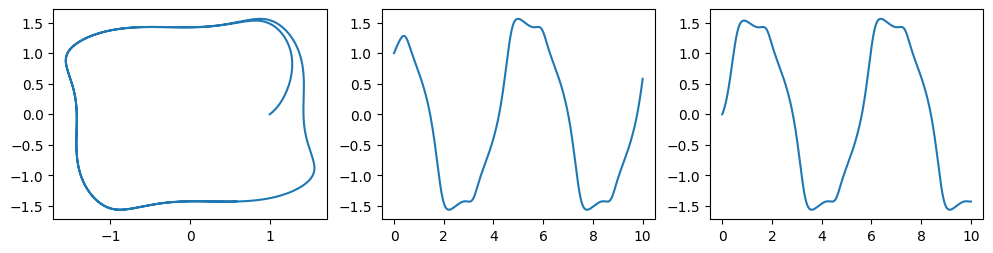

In [84]:
xx1 = true_y.squeeze().T

plt.figure(figsize=(12,6))
ax = plt.subplot(231)
ax.plot(xx1[0,:], xx1[1,:])
ax = plt.subplot(232)
ax.plot(times, xx1[0,:])
ax = plt.subplot(233)
ax.plot(times, xx1[1,:])

In [91]:

class ODEFunc(nn.Module):

    def __init__(self,latent_dim=2,nhidden=20):
        super(ODEFunc, self).__init__()
        
        self.net1 = nn.Sequential(
            nn.Linear(2, 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Linear(50, 2),
        )

        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=2.)
                nn.init.constant_(m.bias, val=0)

    def forward(self, t, y ):
        return self.net(y) 
        
        
def get_batch(func,batch_time = 10, batch_size = 20):
    s = torch.from_numpy(np.random.choice(np.arange(data_size - batch_time, dtype=np.int64), batch_size, replace=False))
    batch_y0 = true_y[s]  # (M, D)
    #batch_y0 = func(s)
    batch_t = times[:batch_time]  # (T)
    batch_y = torch.stack([true_y[s + i] for i in range(batch_time)], dim=0)  # (T, M, D)
    return batch_y0.to(device), batch_t.to(device), batch_y.to(device)

#batch_y0, batch_t, batch_y = get_batch()
#bb = torch.unsqueeze(batch_y0,-1)
#pred_y = odeint(func, batch_y0, batch_t).to(device)
#batch_y0, batch_t, batch_y = get_batch(func)

In [103]:
ll = torch.nn.Linear(2, 2)

In [104]:
x|x

[Parameter containing:
 tensor([[ 0.2086, -0.2467],
         [-0.3422, -0.1748]], requires_grad=True),
 Parameter containing:
 tensor([ 0.3375, -0.3849], requires_grad=True)]

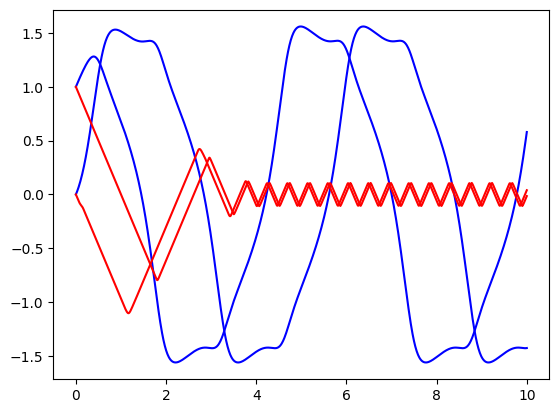

In [92]:
torch.manual_seed(0)
func = ODEFunc().to(device)

pred_y = odeint(func, true_y0, times,method="euler")
plt.plot(times.cpu().squeeze(),true_y.cpu().squeeze(), color="blue")
plt.plot(times.cpu().squeeze(),pred_y.detach().numpy().squeeze(), color="red")

In [93]:
torch.manual_seed(0)
func = ODEFunc().to(device)
optimizer = optim.Adam(func.parameters(), lr=1e-3)

history = {}
history["losses"] = []
history["params"] = [k.detach().numpy() for k in list(func.parameters())]
history["gradients"] = []


for itr in tqdm(range(1, 1000)):
    optimizer.zero_grad()
    batch_y0, batch_t, batch_y = get_batch(func,batch_size=10, batch_time=20)
    pred_y = odeint(func, batch_y0, batch_t).to(device)
    loss = torch.mean(torch.abs(pred_y - batch_y))#/torch.sum(torch.abs(batch_y)))
    loss.backward()
    optimizer.step()

    if itr % 10 == 0:
        with torch.no_grad():
            pred_y = odeint(func, true_y0, times)
            loss = torch.mean(torch.abs(pred_y - true_y))
            print('Iter {:04d} | Total Loss {:.6f}'.format(itr, loss.item()))
            history["losses"].append(loss.item())
            history["params"].append([k.detach().numpy() for k in list(func.parameters())])
            history["gradients"].append([k.grad for k in list(func.parameters())])
    end = time.time()


  1%|█▏                                                                                                          | 11/999 [00:04<10:52,  1.51it/s]

Iter 0010 | Total Loss 1.059998


  2%|██▍                                                                                                         | 22/999 [00:09<09:20,  1.74it/s]

Iter 0020 | Total Loss 1.036768


  3%|███▎                                                                                                        | 31/999 [00:13<11:20,  1.42it/s]

Iter 0030 | Total Loss 1.034499


  4%|████▎                                                                                                       | 40/999 [00:19<17:10,  1.07s/it]

Iter 0040 | Total Loss 1.029709


  5%|█████▌                                                                                                      | 51/999 [00:22<07:07,  2.22it/s]

Iter 0050 | Total Loss 1.027231


  6%|██████▌                                                                                                     | 61/999 [00:24<05:40,  2.76it/s]

Iter 0060 | Total Loss 2.087519


  7%|███████▋                                                                                                    | 71/999 [00:27<06:26,  2.40it/s]

Iter 0070 | Total Loss 2.049237


  8%|████████▊                                                                                                   | 81/999 [00:29<04:38,  3.30it/s]

Iter 0080 | Total Loss 2.008050


  9%|█████████▉                                                                                                  | 92/999 [00:31<02:40,  5.65it/s]

Iter 0090 | Total Loss 2.041427


 10%|██████████▉                                                                                                | 102/999 [00:32<01:55,  7.75it/s]

Iter 0100 | Total Loss 1.421998


 11%|███████████▉                                                                                               | 112/999 [00:33<01:55,  7.68it/s]

Iter 0110 | Total Loss 1.312426


 12%|████████████▉                                                                                              | 121/999 [00:34<01:57,  7.46it/s]

Iter 0120 | Total Loss 1.297464


 13%|██████████████▏                                                                                            | 132/999 [00:35<01:47,  8.10it/s]

Iter 0130 | Total Loss 1.295558


 14%|███████████████▎                                                                                           | 143/999 [00:37<02:31,  5.65it/s]

Iter 0140 | Total Loss 1.268407


 15%|████████████████▍                                                                                          | 153/999 [00:38<01:29,  9.44it/s]

Iter 0150 | Total Loss 4.785002


 16%|█████████████████▍                                                                                         | 163/999 [00:39<01:14, 11.16it/s]

Iter 0160 | Total Loss 4.824284


 17%|██████████████████▎                                                                                        | 171/999 [00:39<01:32,  8.99it/s]

Iter 0170 | Total Loss 4.797884


 18%|███████████████████▌                                                                                       | 183/999 [00:40<01:09, 11.68it/s]

Iter 0180 | Total Loss 4.708392


 19%|████████████████████▋                                                                                      | 193/999 [00:41<01:13, 11.01it/s]

Iter 0190 | Total Loss 4.660388


 20%|█████████████████████▌                                                                                     | 201/999 [00:42<01:42,  7.76it/s]

Iter 0200 | Total Loss 4.239462


 21%|██████████████████████▋                                                                                    | 212/999 [00:44<01:59,  6.60it/s]

Iter 0210 | Total Loss 1.497268


 22%|███████████████████████▋                                                                                   | 221/999 [00:45<02:14,  5.80it/s]

Iter 0220 | Total Loss 1.453531


 23%|████████████████████████▋                                                                                  | 231/999 [00:47<03:28,  3.69it/s]

Iter 0230 | Total Loss 1.457665


 24%|█████████████████████████▊                                                                                 | 241/999 [00:49<03:43,  3.39it/s]

Iter 0240 | Total Loss 1.503487


 25%|██████████████████████████▉                                                                                | 252/999 [00:51<02:33,  4.86it/s]

Iter 0250 | Total Loss 1.453607


 26%|███████████████████████████▉                                                                               | 261/999 [00:52<02:51,  4.30it/s]

Iter 0260 | Total Loss 1.447580


 27%|█████████████████████████████                                                                              | 271/999 [00:54<03:13,  3.76it/s]

Iter 0270 | Total Loss 1.452081


 28%|██████████████████████████████▏                                                                            | 282/999 [00:57<03:19,  3.60it/s]

Iter 0280 | Total Loss 1.492410


 29%|███████████████████████████████▎                                                                           | 292/999 [00:58<02:53,  4.08it/s]

Iter 0290 | Total Loss 1.466106


 30%|████████████████████████████████▏                                                                          | 301/999 [01:01<03:45,  3.10it/s]

Iter 0300 | Total Loss 1.466853


 31%|█████████████████████████████████▍                                                                         | 312/999 [01:02<02:25,  4.73it/s]

Iter 0310 | Total Loss 1.429204


 32%|██████████████████████████████████▌                                                                        | 323/999 [01:04<01:59,  5.65it/s]

Iter 0320 | Total Loss 1.391604


 33%|███████████████████████████████████▎                                                                       | 330/999 [01:06<02:29,  4.48it/s]

Iter 0330 | Total Loss 1.420727


 34%|████████████████████████████████████▋                                                                      | 342/999 [01:08<02:54,  3.77it/s]

Iter 0340 | Total Loss 1.397647


 35%|█████████████████████████████████████▋                                                                     | 352/999 [01:09<02:02,  5.28it/s]

Iter 0350 | Total Loss 1.417984


 36%|██████████████████████████████████████▊                                                                    | 362/999 [01:11<02:01,  5.25it/s]

Iter 0360 | Total Loss 1.418743


 37%|███████████████████████████████████████▉                                                                   | 373/999 [01:13<02:18,  4.51it/s]

Iter 0370 | Total Loss 1.445000


 38%|█████████████████████████████████████████                                                                  | 383/999 [01:15<02:02,  5.02it/s]

Iter 0380 | Total Loss 1.433960


 39%|█████████████████████████████████████████▉                                                                 | 391/999 [01:17<02:42,  3.73it/s]

Iter 0390 | Total Loss 1.440026


 40%|███████████████████████████████████████████▏                                                               | 403/999 [01:19<01:49,  5.43it/s]

Iter 0400 | Total Loss 1.433048


 41%|████████████████████████████████████████████                                                               | 411/999 [01:20<02:19,  4.23it/s]

Iter 0410 | Total Loss 1.417698


 42%|█████████████████████████████████████████████▏                                                             | 422/999 [01:22<02:04,  4.65it/s]

Iter 0420 | Total Loss 1.435241


 43%|██████████████████████████████████████████████▎                                                            | 432/999 [01:24<01:54,  4.94it/s]

Iter 0430 | Total Loss 1.408167


 44%|███████████████████████████████████████████████▎                                                           | 442/999 [01:26<02:07,  4.36it/s]

Iter 0440 | Total Loss 1.401821


 45%|████████████████████████████████████████████████▎                                                          | 451/999 [01:27<02:05,  4.36it/s]

Iter 0450 | Total Loss 1.399238


 46%|█████████████████████████████████████████████████▍                                                         | 461/999 [01:29<02:08,  4.18it/s]

Iter 0460 | Total Loss 1.398502


 47%|██████████████████████████████████████████████████▌                                                        | 472/999 [01:31<01:43,  5.11it/s]

Iter 0470 | Total Loss 1.326589


 48%|███████████████████████████████████████████████████▌                                                       | 481/999 [01:32<01:41,  5.11it/s]

Iter 0480 | Total Loss 1.419172


 49%|████████████████████████████████████████████████████▌                                                      | 491/999 [01:34<01:57,  4.31it/s]

Iter 0490 | Total Loss 1.374053


 50%|█████████████████████████████████████████████████████▊                                                     | 502/999 [01:36<01:43,  4.80it/s]

Iter 0500 | Total Loss 1.424809


 51%|██████████████████████████████████████████████████████▋                                                    | 511/999 [01:38<01:43,  4.72it/s]

Iter 0510 | Total Loss 1.200998


 52%|███████████████████████████████████████████████████████▊                                                   | 521/999 [01:39<01:51,  4.30it/s]

Iter 0520 | Total Loss 1.351462


 53%|████████████████████████████████████████████████████████▉                                                  | 532/999 [01:41<01:23,  5.61it/s]

Iter 0530 | Total Loss 1.377340


 54%|█████████████████████████████████████████████████████████▉                                                 | 541/999 [01:43<01:44,  4.38it/s]

Iter 0540 | Total Loss 1.243261


 55%|███████████████████████████████████████████████████████████                                                | 552/999 [01:45<01:27,  5.09it/s]

Iter 0550 | Total Loss 1.325318


 56%|████████████████████████████████████████████████████████████▏                                              | 562/999 [01:46<01:24,  5.14it/s]

Iter 0560 | Total Loss 1.008391


 57%|█████████████████████████████████████████████████████████████▏                                             | 571/999 [01:48<01:23,  5.11it/s]

Iter 0570 | Total Loss 1.217710


 58%|██████████████████████████████████████████████████████████████▏                                            | 581/999 [01:49<01:21,  5.11it/s]

Iter 0580 | Total Loss 1.158066


 59%|███████████████████████████████████████████████████████████████▎                                           | 591/999 [01:51<01:08,  5.96it/s]

Iter 0590 | Total Loss 1.186109


 60%|████████████████████████████████████████████████████████████████▎                                          | 601/999 [01:52<01:25,  4.64it/s]

Iter 0600 | Total Loss 1.234262


 61%|█████████████████████████████████████████████████████████████████▍                                         | 611/999 [01:54<01:20,  4.80it/s]

Iter 0610 | Total Loss 1.198670


 62%|██████████████████████████████████████████████████████████████████▌                                        | 621/999 [01:55<01:14,  5.08it/s]

Iter 0620 | Total Loss 1.159812


 63%|███████████████████████████████████████████████████████████████████▌                                       | 631/999 [01:57<01:16,  4.81it/s]

Iter 0630 | Total Loss 0.987847


 64%|████████████████████████████████████████████████████████████████████▋                                      | 641/999 [01:59<01:14,  4.81it/s]

Iter 0640 | Total Loss 1.036698


 65%|█████████████████████████████████████████████████████████████████████▋                                     | 651/999 [02:00<01:06,  5.22it/s]

Iter 0650 | Total Loss 1.154532


 66%|██████████████████████████████████████████████████████████████████████▊                                    | 661/999 [02:01<01:03,  5.30it/s]

Iter 0660 | Total Loss 1.132752


 67%|███████████████████████████████████████████████████████████████████████▊                                   | 671/999 [02:03<01:00,  5.44it/s]

Iter 0670 | Total Loss 1.122267


 68%|████████████████████████████████████████████████████████████████████████▉                                  | 681/999 [02:04<00:53,  5.98it/s]

Iter 0680 | Total Loss 1.144147


 69%|██████████████████████████████████████████████████████████████████████████                                 | 692/999 [02:06<00:43,  7.02it/s]

Iter 0690 | Total Loss 1.161968


 70%|███████████████████████████████████████████████████████████████████████████                                | 701/999 [02:07<00:53,  5.57it/s]

Iter 0700 | Total Loss 1.241891


 71%|████████████████████████████████████████████████████████████████████████████▏                              | 711/999 [02:08<00:46,  6.13it/s]

Iter 0710 | Total Loss 1.232121


 72%|█████████████████████████████████████████████████████████████████████████████▎                             | 722/999 [02:10<00:46,  5.92it/s]

Iter 0720 | Total Loss 1.251585


 73%|██████████████████████████████████████████████████████████████████████████████▍                            | 732/999 [02:11<00:39,  6.75it/s]

Iter 0730 | Total Loss 1.251513


 74%|███████████████████████████████████████████████████████████████████████████████▎                           | 741/999 [02:13<00:54,  4.77it/s]

Iter 0740 | Total Loss 1.235003


 75%|████████████████████████████████████████████████████████████████████████████████▍                          | 751/999 [02:14<00:39,  6.26it/s]

Iter 0750 | Total Loss 1.273715


 76%|█████████████████████████████████████████████████████████████████████████████████▌                         | 761/999 [02:15<00:39,  5.97it/s]

Iter 0760 | Total Loss 1.242667


 77%|██████████████████████████████████████████████████████████████████████████████████▌                        | 771/999 [02:16<00:42,  5.41it/s]

Iter 0770 | Total Loss 1.250037


 78%|███████████████████████████████████████████████████████████████████████████████████▋                       | 781/999 [02:18<00:32,  6.71it/s]

Iter 0780 | Total Loss 1.229433


 79%|████████████████████████████████████████████████████████████████████████████████████▋                      | 791/999 [02:19<00:30,  6.93it/s]

Iter 0790 | Total Loss 1.218979


 80%|█████████████████████████████████████████████████████████████████████████████████████▉                     | 802/999 [02:20<00:29,  6.65it/s]

Iter 0800 | Total Loss 1.213094


 81%|██████████████████████████████████████████████████████████████████████████████████████▉                    | 812/999 [02:21<00:25,  7.48it/s]

Iter 0810 | Total Loss 1.238891


 82%|████████████████████████████████████████████████████████████████████████████████████████                   | 822/999 [02:23<00:38,  4.55it/s]

Iter 0820 | Total Loss 0.929865


 83%|█████████████████████████████████████████████████████████████████████████████████████████                  | 832/999 [02:28<01:23,  2.01it/s]

Iter 0830 | Total Loss 0.851128


 84%|██████████████████████████████████████████████████████████████████████████████████████████▎                | 843/999 [02:31<01:01,  2.54it/s]

Iter 0840 | Total Loss 0.831813


 85%|███████████████████████████████████████████████████████████████████████████████████████████▏               | 851/999 [02:33<00:55,  2.69it/s]

Iter 0850 | Total Loss 0.874100


 86%|████████████████████████████████████████████████████████████████████████████████████████████▍              | 863/999 [02:35<00:30,  4.50it/s]

Iter 0860 | Total Loss 0.829862


 87%|█████████████████████████████████████████████████████████████████████████████████████████████▍             | 872/999 [02:37<00:27,  4.64it/s]

Iter 0870 | Total Loss 0.810241


 88%|██████████████████████████████████████████████████████████████████████████████████████████████▌            | 883/999 [02:39<00:21,  5.30it/s]

Iter 0880 | Total Loss 0.813496


 89%|███████████████████████████████████████████████████████████████████████████████████████████████▋           | 893/999 [02:40<00:21,  5.04it/s]

Iter 0890 | Total Loss 0.851151


 90%|████████████████████████████████████████████████████████████████████████████████████████████████▌          | 902/999 [02:42<00:19,  5.06it/s]

Iter 0900 | Total Loss 0.808436


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████▋         | 912/999 [02:44<00:18,  4.63it/s]

Iter 0910 | Total Loss 0.822075


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████▊        | 922/999 [02:46<00:16,  4.77it/s]

Iter 0920 | Total Loss 0.812720


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████▉       | 933/999 [02:48<00:12,  5.37it/s]

Iter 0930 | Total Loss 0.823657


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████      | 943/999 [02:50<00:12,  4.53it/s]

Iter 0940 | Total Loss 0.823778


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 952/999 [02:51<00:09,  4.86it/s]

Iter 0950 | Total Loss 0.831779


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████    | 962/999 [02:53<00:07,  4.90it/s]

Iter 0960 | Total Loss 0.822916


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 973/999 [02:55<00:05,  5.06it/s]

Iter 0970 | Total Loss 0.808208


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 983/999 [02:56<00:03,  5.15it/s]

Iter 0980 | Total Loss 0.822709


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 993/999 [02:58<00:01,  5.04it/s]

Iter 0990 | Total Loss 0.802095


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 999/999 [02:58<00:00,  5.58it/s]


In [94]:
for itr in tqdm(range(1, 10000)):
    optimizer.zero_grad()
    batch_y0, batch_t, batch_y = get_batch(func,batch_size=10, batch_time=20)
    pred_y = odeint(func, batch_y0, batch_t).to(device)
    loss = torch.mean(torch.abs(pred_y - batch_y))#/torch.sum(torch.abs(batch_y)))
    loss.backward()
    optimizer.step()

    if itr % 10 == 0:
        with torch.no_grad():
            pred_y = odeint(func, true_y0, times)
            loss = torch.mean(torch.abs(pred_y - true_y))
            print('Iter {:04d} | Total Loss {:.6f}'.format(itr, loss.item()))
            history["losses"].append(loss.item())
            history["params"].append([k.detach().numpy() for k in list(func.parameters())])
            history["gradients"].append([k.grad for k in list(func.parameters())])
    end = time.time()


  0%|▏                                                                                                          | 12/9999 [00:01<27:28,  6.06it/s]

Iter 0010 | Total Loss 0.856117


  0%|▏                                                                                                          | 21/9999 [00:03<37:44,  4.41it/s]

Iter 0020 | Total Loss 0.805779


  0%|▎                                                                                                          | 33/9999 [00:04<32:16,  5.15it/s]

Iter 0030 | Total Loss 0.818901


  0%|▍                                                                                                          | 44/9999 [00:06<24:00,  6.91it/s]

Iter 0040 | Total Loss 1.186380


  1%|▌                                                                                                          | 52/9999 [00:07<32:55,  5.03it/s]

Iter 0050 | Total Loss 0.825144


  1%|▋                                                                                                          | 62/9999 [00:09<32:05,  5.16it/s]

Iter 0060 | Total Loss 0.811220


  1%|▊                                                                                                          | 73/9999 [00:11<29:14,  5.66it/s]

Iter 0070 | Total Loss 0.810666


  1%|▉                                                                                                          | 82/9999 [00:12<29:51,  5.53it/s]

Iter 0080 | Total Loss 0.808285


  1%|▉                                                                                                          | 92/9999 [00:14<30:48,  5.36it/s]

Iter 0090 | Total Loss 0.752486


  1%|█                                                                                                         | 103/9999 [00:15<24:12,  6.81it/s]

Iter 0100 | Total Loss 1.075432


  1%|█▏                                                                                                        | 112/9999 [00:17<25:08,  6.55it/s]

Iter 0110 | Total Loss 0.888597


  1%|█▎                                                                                                        | 122/9999 [00:18<27:08,  6.06it/s]

Iter 0120 | Total Loss 0.835008


  1%|█▍                                                                                                        | 132/9999 [00:20<31:29,  5.22it/s]

Iter 0130 | Total Loss 0.779599


  1%|█▌                                                                                                        | 143/9999 [00:21<30:08,  5.45it/s]

Iter 0140 | Total Loss 0.835628


  2%|█▌                                                                                                        | 153/9999 [00:23<30:44,  5.34it/s]

Iter 0150 | Total Loss 0.856411


  2%|█▋                                                                                                        | 162/9999 [00:24<29:29,  5.56it/s]

Iter 0160 | Total Loss 0.809784


  2%|█▊                                                                                                        | 172/9999 [00:26<30:49,  5.31it/s]

Iter 0170 | Total Loss 0.824039


  2%|█▉                                                                                                        | 182/9999 [00:27<25:56,  6.31it/s]

Iter 0180 | Total Loss 1.139131


  2%|██                                                                                                        | 192/9999 [00:29<31:18,  5.22it/s]

Iter 0190 | Total Loss 0.813097


  2%|██▏                                                                                                       | 202/9999 [00:31<28:45,  5.68it/s]

Iter 0200 | Total Loss 0.897235


  2%|██▏                                                                                                       | 212/9999 [00:32<31:17,  5.21it/s]

Iter 0210 | Total Loss 0.813680


  2%|██▎                                                                                                       | 222/9999 [00:34<26:41,  6.11it/s]

Iter 0220 | Total Loss 0.829589


  2%|██▍                                                                                                       | 232/9999 [00:35<21:55,  7.43it/s]

Iter 0230 | Total Loss 1.449380


  2%|██▌                                                                                                       | 243/9999 [00:36<25:49,  6.30it/s]

Iter 0240 | Total Loss 0.889245


  3%|██▋                                                                                                       | 253/9999 [00:38<30:15,  5.37it/s]

Iter 0250 | Total Loss 0.819051


  3%|██▊                                                                                                       | 263/9999 [00:39<28:21,  5.72it/s]

Iter 0260 | Total Loss 0.882906


  3%|██▉                                                                                                       | 273/9999 [00:41<29:10,  5.56it/s]

Iter 0270 | Total Loss 0.913038


  3%|███                                                                                                       | 283/9999 [00:42<26:45,  6.05it/s]

Iter 0280 | Total Loss 0.854727


  3%|███                                                                                                       | 292/9999 [00:44<26:54,  6.01it/s]

Iter 0290 | Total Loss 0.828671


  3%|███▏                                                                                                      | 303/9999 [00:45<26:01,  6.21it/s]

Iter 0300 | Total Loss 0.803786


  3%|███▎                                                                                                      | 312/9999 [00:47<23:06,  6.99it/s]

Iter 0310 | Total Loss 1.393379


  3%|███▍                                                                                                      | 322/9999 [00:48<23:51,  6.76it/s]

Iter 0320 | Total Loss 1.211434


  3%|███▌                                                                                                      | 333/9999 [00:49<21:52,  7.36it/s]

Iter 0330 | Total Loss 1.241145


  3%|███▋                                                                                                      | 343/9999 [00:50<18:12,  8.84it/s]

Iter 0340 | Total Loss 1.537265


  4%|███▋                                                                                                      | 353/9999 [00:52<23:37,  6.80it/s]

Iter 0350 | Total Loss 0.829602


  4%|███▊                                                                                                      | 362/9999 [00:53<27:38,  5.81it/s]

Iter 0360 | Total Loss 0.796892


  4%|███▉                                                                                                      | 372/9999 [00:54<24:57,  6.43it/s]

Iter 0370 | Total Loss 1.053304


  4%|████                                                                                                      | 382/9999 [00:56<29:21,  5.46it/s]

Iter 0380 | Total Loss 0.785930


  4%|████▏                                                                                                     | 393/9999 [00:58<28:43,  5.57it/s]

Iter 0390 | Total Loss 0.783974


  4%|████▎                                                                                                     | 402/9999 [00:59<31:44,  5.04it/s]

Iter 0400 | Total Loss 0.854223


  4%|████▎                                                                                                     | 411/9999 [01:02<53:09,  3.01it/s]

Iter 0410 | Total Loss 0.861354


  4%|████▍                                                                                                     | 422/9999 [01:04<39:44,  4.02it/s]

Iter 0420 | Total Loss 1.148767


  4%|████▌                                                                                                     | 432/9999 [01:06<33:51,  4.71it/s]

Iter 0430 | Total Loss 0.810060


  4%|████▋                                                                                                     | 442/9999 [01:08<32:32,  4.90it/s]

Iter 0440 | Total Loss 1.617675


  5%|████▊                                                                                                     | 450/9999 [01:09<38:05,  4.18it/s]

Iter 0450 | Total Loss 1.402642


  5%|████▉                                                                                                     | 462/9999 [01:12<45:57,  3.46it/s]

Iter 0460 | Total Loss 0.817053


  5%|████▉                                                                                                     | 471/9999 [01:13<30:38,  5.18it/s]

Iter 0470 | Total Loss 1.498733


  5%|█████                                                                                                     | 482/9999 [01:15<28:22,  5.59it/s]

Iter 0480 | Total Loss 0.829641


  5%|█████▏                                                                                                    | 492/9999 [01:17<30:37,  5.18it/s]

Iter 0490 | Total Loss 0.761858


  5%|█████▎                                                                                                    | 500/9999 [01:19<47:51,  3.31it/s]

Iter 0500 | Total Loss 0.809771


  5%|█████▍                                                                                                    | 513/9999 [01:21<32:08,  4.92it/s]

Iter 0510 | Total Loss 1.283206


  5%|█████▌                                                                                                    | 523/9999 [01:22<22:24,  7.05it/s]

Iter 0520 | Total Loss 1.305294


  5%|█████▋                                                                                                    | 532/9999 [01:24<30:16,  5.21it/s]

Iter 0530 | Total Loss 0.769312


  5%|█████▋                                                                                                    | 542/9999 [01:25<24:55,  6.33it/s]

Iter 0540 | Total Loss 0.981726


  6%|█████▊                                                                                                    | 553/9999 [01:26<19:02,  8.27it/s]

Iter 0550 | Total Loss 0.865490


  6%|█████▉                                                                                                    | 562/9999 [01:28<35:02,  4.49it/s]

Iter 0560 | Total Loss 0.767467


  6%|██████                                                                                                    | 573/9999 [01:31<32:40,  4.81it/s]

Iter 0570 | Total Loss 0.776891


  6%|██████▏                                                                                                   | 581/9999 [01:32<37:55,  4.14it/s]

Iter 0580 | Total Loss 1.008901


  6%|██████▎                                                                                                   | 592/9999 [01:34<30:57,  5.07it/s]

Iter 0590 | Total Loss 0.919444


  6%|██████▍                                                                                                   | 602/9999 [01:36<30:17,  5.17it/s]

Iter 0600 | Total Loss 0.815980


  6%|██████▍                                                                                                   | 612/9999 [01:37<32:27,  4.82it/s]

Iter 0610 | Total Loss 0.767219


  6%|██████▌                                                                                                   | 622/9999 [01:39<27:59,  5.58it/s]

Iter 0620 | Total Loss 0.794973


  6%|██████▋                                                                                                   | 633/9999 [01:41<27:35,  5.66it/s]

Iter 0630 | Total Loss 0.804995


  6%|██████▊                                                                                                   | 643/9999 [01:42<24:58,  6.25it/s]

Iter 0640 | Total Loss 0.950754


  7%|██████▉                                                                                                   | 653/9999 [01:44<26:50,  5.80it/s]

Iter 0650 | Total Loss 0.777855


  7%|███████                                                                                                   | 663/9999 [01:45<22:02,  7.06it/s]

Iter 0660 | Total Loss 0.968331


  7%|███████▏                                                                                                  | 673/9999 [01:46<27:23,  5.67it/s]

Iter 0670 | Total Loss 0.835906


  7%|███████▏                                                                                                  | 683/9999 [01:48<29:34,  5.25it/s]

Iter 0680 | Total Loss 0.825162


  7%|███████▎                                                                                                  | 693/9999 [01:50<28:43,  5.40it/s]

Iter 0690 | Total Loss 0.734031


  7%|███████▍                                                                                                  | 702/9999 [01:52<35:10,  4.40it/s]

Iter 0700 | Total Loss 0.821574


  7%|███████▌                                                                                                  | 712/9999 [01:53<23:50,  6.49it/s]

Iter 0710 | Total Loss 0.984137


  7%|███████▋                                                                                                  | 722/9999 [01:55<31:01,  4.98it/s]

Iter 0720 | Total Loss 0.834942


  7%|███████▊                                                                                                  | 733/9999 [01:56<17:55,  8.62it/s]

Iter 0730 | Total Loss 1.487532


  7%|███████▉                                                                                                  | 743/9999 [01:58<27:04,  5.70it/s]

Iter 0740 | Total Loss 0.787083


  8%|███████▉                                                                                                  | 754/9999 [01:59<26:23,  5.84it/s]

Iter 0750 | Total Loss 0.752885


  8%|████████                                                                                                  | 763/9999 [02:01<28:29,  5.40it/s]

Iter 0760 | Total Loss 0.792768


  8%|████████▏                                                                                                 | 774/9999 [02:02<23:21,  6.58it/s]

Iter 0770 | Total Loss 1.178072


  8%|████████▎                                                                                                 | 782/9999 [02:04<22:37,  6.79it/s]

Iter 0780 | Total Loss 1.191120


  8%|████████▍                                                                                                 | 793/9999 [02:05<19:39,  7.81it/s]

Iter 0790 | Total Loss 1.453635


  8%|████████▌                                                                                                 | 803/9999 [02:06<23:36,  6.49it/s]

Iter 0800 | Total Loss 0.827055


  8%|████████▌                                                                                                 | 812/9999 [02:08<22:19,  6.86it/s]

Iter 0810 | Total Loss 1.224405


  8%|████████▋                                                                                                 | 823/9999 [02:09<18:20,  8.34it/s]

Iter 0820 | Total Loss 1.466860


  8%|████████▊                                                                                                 | 833/9999 [02:10<18:37,  8.20it/s]

Iter 0830 | Total Loss 1.465798


  8%|████████▉                                                                                                 | 843/9999 [02:11<20:03,  7.61it/s]

Iter 0840 | Total Loss 0.951759


  9%|█████████                                                                                                 | 853/9999 [02:13<22:27,  6.79it/s]

Iter 0850 | Total Loss 0.887161


  9%|█████████▏                                                                                                | 863/9999 [02:14<25:17,  6.02it/s]

Iter 0860 | Total Loss 0.795552


  9%|█████████▎                                                                                                | 873/9999 [02:15<22:30,  6.76it/s]

Iter 0870 | Total Loss 1.335893


  9%|█████████▎                                                                                                | 883/9999 [02:17<19:41,  7.72it/s]

Iter 0880 | Total Loss 1.322633


  9%|█████████▍                                                                                                | 892/9999 [02:18<21:23,  7.10it/s]

Iter 0890 | Total Loss 1.289210


  9%|█████████▌                                                                                                | 903/9999 [02:19<17:43,  8.55it/s]

Iter 0900 | Total Loss 1.535738


  9%|█████████▋                                                                                                | 911/9999 [02:20<33:04,  4.58it/s]

Iter 0910 | Total Loss 0.776728


  9%|█████████▊                                                                                                | 923/9999 [02:22<21:44,  6.96it/s]

Iter 0920 | Total Loss 1.144305


  9%|█████████▉                                                                                                | 933/9999 [02:23<23:23,  6.46it/s]

Iter 0930 | Total Loss 1.213525


  9%|█████████▉                                                                                                | 943/9999 [02:24<22:08,  6.82it/s]

Iter 0940 | Total Loss 0.974398


 10%|██████████                                                                                                | 953/9999 [02:26<21:59,  6.86it/s]

Iter 0950 | Total Loss 1.267728


 10%|██████████▏                                                                                               | 963/9999 [02:27<17:56,  8.39it/s]

Iter 0960 | Total Loss 1.485459


 10%|██████████▎                                                                                               | 972/9999 [02:28<19:38,  7.66it/s]

Iter 0970 | Total Loss 1.134388


 10%|██████████▍                                                                                               | 983/9999 [02:29<21:25,  7.02it/s]

Iter 0980 | Total Loss 0.622233


 10%|██████████▌                                                                                               | 993/9999 [02:31<23:54,  6.28it/s]

Iter 0990 | Total Loss 0.760163


 10%|██████████▌                                                                                              | 1003/9999 [02:32<22:37,  6.63it/s]

Iter 1000 | Total Loss 0.844800


 10%|██████████▋                                                                                              | 1012/9999 [02:34<23:55,  6.26it/s]

Iter 1010 | Total Loss 0.836994


 10%|██████████▋                                                                                              | 1023/9999 [02:35<23:45,  6.30it/s]

Iter 1020 | Total Loss 0.801646


 10%|██████████▊                                                                                              | 1032/9999 [02:37<25:34,  5.84it/s]

Iter 1030 | Total Loss 0.942455


 10%|██████████▉                                                                                              | 1042/9999 [02:38<24:46,  6.03it/s]

Iter 1040 | Total Loss 1.295139


 11%|███████████                                                                                              | 1054/9999 [02:39<18:48,  7.92it/s]

Iter 1050 | Total Loss 1.459917


 11%|███████████▏                                                                                             | 1061/9999 [02:41<33:16,  4.48it/s]

Iter 1060 | Total Loss 0.819334


 11%|███████████▎                                                                                             | 1073/9999 [02:42<19:13,  7.74it/s]

Iter 1070 | Total Loss 1.246000


 11%|███████████▍                                                                                             | 1084/9999 [02:44<22:44,  6.53it/s]

Iter 1080 | Total Loss 0.815396


 11%|███████████▍                                                                                             | 1093/9999 [02:45<19:59,  7.42it/s]

Iter 1090 | Total Loss 0.732836


 11%|███████████▌                                                                                             | 1103/9999 [02:46<16:34,  8.95it/s]

Iter 1100 | Total Loss 1.485757


 11%|███████████▋                                                                                             | 1113/9999 [02:47<17:25,  8.50it/s]

Iter 1110 | Total Loss 0.935526


 11%|███████████▊                                                                                             | 1122/9999 [02:48<24:25,  6.06it/s]

Iter 1120 | Total Loss 0.779564


 11%|███████████▉                                                                                             | 1132/9999 [02:50<21:33,  6.85it/s]

Iter 1130 | Total Loss 1.222139


 11%|████████████                                                                                             | 1143/9999 [02:51<17:34,  8.40it/s]

Iter 1140 | Total Loss 1.273628


 12%|████████████                                                                                             | 1154/9999 [02:52<20:38,  7.14it/s]

Iter 1150 | Total Loss 0.796004


 12%|████████████▏                                                                                            | 1163/9999 [02:54<21:51,  6.73it/s]

Iter 1160 | Total Loss 0.821659


 12%|████████████▎                                                                                            | 1173/9999 [02:55<18:51,  7.80it/s]

Iter 1170 | Total Loss 1.036798


 12%|████████████▍                                                                                            | 1183/9999 [02:56<23:53,  6.15it/s]

Iter 1180 | Total Loss 0.823062


 12%|████████████▌                                                                                            | 1192/9999 [02:57<20:38,  7.11it/s]

Iter 1190 | Total Loss 1.521975


 12%|████████████▌                                                                                            | 1202/9999 [02:58<18:25,  7.96it/s]

Iter 1200 | Total Loss 1.462700


 12%|████████████▋                                                                                            | 1214/9999 [03:00<17:05,  8.57it/s]

Iter 1210 | Total Loss 1.043082


 12%|████████████▊                                                                                            | 1223/9999 [03:01<17:04,  8.56it/s]

Iter 1220 | Total Loss 1.191748


 12%|████████████▉                                                                                            | 1232/9999 [03:02<26:16,  5.56it/s]

Iter 1230 | Total Loss 0.793299


 12%|█████████████                                                                                            | 1242/9999 [03:04<21:58,  6.64it/s]

Iter 1240 | Total Loss 1.341756


 13%|█████████████▏                                                                                           | 1253/9999 [03:05<17:58,  8.11it/s]

Iter 1250 | Total Loss 1.441240


 13%|█████████████▎                                                                                           | 1263/9999 [03:06<17:27,  8.34it/s]

Iter 1260 | Total Loss 1.401154


 13%|█████████████▎                                                                                           | 1272/9999 [03:07<19:52,  7.32it/s]

Iter 1270 | Total Loss 1.369559


 13%|█████████████▍                                                                                           | 1283/9999 [03:08<17:00,  8.54it/s]

Iter 1280 | Total Loss 1.056427


 13%|█████████████▌                                                                                           | 1293/9999 [03:09<17:14,  8.42it/s]

Iter 1290 | Total Loss 1.350090


 13%|█████████████▋                                                                                           | 1303/9999 [03:10<17:22,  8.34it/s]

Iter 1300 | Total Loss 1.283474


 13%|█████████████▊                                                                                           | 1314/9999 [03:12<16:26,  8.80it/s]

Iter 1310 | Total Loss 1.416552


 13%|█████████████▉                                                                                           | 1324/9999 [03:13<17:22,  8.32it/s]

Iter 1320 | Total Loss 1.362738


 13%|█████████████▉                                                                                           | 1332/9999 [03:14<24:48,  5.82it/s]

Iter 1330 | Total Loss 0.797508


 13%|██████████████                                                                                           | 1344/9999 [03:16<19:51,  7.26it/s]

Iter 1340 | Total Loss 1.442435


 14%|██████████████▏                                                                                          | 1352/9999 [03:17<20:48,  6.93it/s]

Iter 1350 | Total Loss 0.897782


 14%|██████████████▎                                                                                          | 1362/9999 [03:18<20:44,  6.94it/s]

Iter 1360 | Total Loss 1.203754


 14%|██████████████▍                                                                                          | 1372/9999 [03:19<19:09,  7.51it/s]

Iter 1370 | Total Loss 0.902561


 14%|██████████████▌                                                                                          | 1384/9999 [03:21<17:26,  8.23it/s]

Iter 1380 | Total Loss 1.369228


 14%|██████████████▋                                                                                          | 1393/9999 [03:22<17:18,  8.28it/s]

Iter 1390 | Total Loss 1.130317


 14%|██████████████▋                                                                                          | 1403/9999 [03:23<17:06,  8.37it/s]

Iter 1400 | Total Loss 1.345817


 14%|██████████████▊                                                                                          | 1413/9999 [03:24<17:20,  8.25it/s]

Iter 1410 | Total Loss 1.325069


 14%|██████████████▉                                                                                          | 1423/9999 [03:25<17:11,  8.31it/s]

Iter 1420 | Total Loss 0.974748


 14%|███████████████                                                                                          | 1434/9999 [03:27<16:45,  8.51it/s]

Iter 1430 | Total Loss 1.166484


 14%|███████████████▏                                                                                         | 1443/9999 [03:28<16:21,  8.72it/s]

Iter 1440 | Total Loss 1.363224


 15%|███████████████▏                                                                                         | 1451/9999 [03:29<21:43,  6.56it/s]

Iter 1450 | Total Loss 1.065361


 15%|███████████████▎                                                                                         | 1463/9999 [03:30<15:57,  8.91it/s]

Iter 1460 | Total Loss 1.358309


 15%|███████████████▍                                                                                         | 1472/9999 [03:31<18:36,  7.64it/s]

Iter 1470 | Total Loss 1.354485


 15%|███████████████▌                                                                                         | 1483/9999 [03:32<19:55,  7.12it/s]

Iter 1480 | Total Loss 0.788186


 15%|███████████████▋                                                                                         | 1491/9999 [03:33<21:54,  6.47it/s]

Iter 1490 | Total Loss 1.311324


 15%|███████████████▊                                                                                         | 1502/9999 [03:35<18:07,  7.81it/s]

Iter 1500 | Total Loss 1.124191


 15%|███████████████▉                                                                                         | 1514/9999 [03:36<21:32,  6.57it/s]

Iter 1510 | Total Loss 0.774380


 15%|███████████████▉                                                                                         | 1522/9999 [03:37<19:39,  7.19it/s]

Iter 1520 | Total Loss 1.295597


 15%|████████████████                                                                                         | 1532/9999 [03:38<18:57,  7.44it/s]

Iter 1530 | Total Loss 0.802230


 15%|████████████████▏                                                                                        | 1543/9999 [03:40<16:07,  8.74it/s]

Iter 1540 | Total Loss 1.501707


 16%|████████████████▎                                                                                        | 1554/9999 [03:41<16:08,  8.72it/s]

Iter 1550 | Total Loss 1.107501


 16%|████████████████▍                                                                                        | 1563/9999 [03:42<15:22,  9.14it/s]

Iter 1560 | Total Loss 1.430756


 16%|████████████████▌                                                                                        | 1572/9999 [03:43<18:06,  7.76it/s]

Iter 1570 | Total Loss 1.206083


 16%|████████████████▌                                                                                        | 1582/9999 [03:44<18:20,  7.65it/s]

Iter 1580 | Total Loss 1.272204


 16%|████████████████▋                                                                                        | 1593/9999 [03:45<17:12,  8.14it/s]

Iter 1590 | Total Loss 0.876103


 16%|████████████████▊                                                                                        | 1603/9999 [03:46<16:24,  8.53it/s]

Iter 1600 | Total Loss 1.167734


 16%|████████████████▉                                                                                        | 1614/9999 [03:48<15:28,  9.03it/s]

Iter 1610 | Total Loss 1.356869


 16%|█████████████████                                                                                        | 1623/9999 [03:49<15:18,  9.12it/s]

Iter 1620 | Total Loss 1.367068


 16%|█████████████████▏                                                                                       | 1633/9999 [03:50<18:10,  7.67it/s]

Iter 1630 | Total Loss 1.263705


 16%|█████████████████▏                                                                                       | 1642/9999 [03:51<20:18,  6.86it/s]

Iter 1640 | Total Loss 1.311630


 17%|█████████████████▎                                                                                       | 1653/9999 [03:52<19:23,  7.17it/s]

Iter 1650 | Total Loss 1.383247


 17%|█████████████████▍                                                                                       | 1663/9999 [03:54<18:19,  7.58it/s]

Iter 1660 | Total Loss 1.400232


 17%|█████████████████▌                                                                                       | 1674/9999 [03:55<16:59,  8.16it/s]

Iter 1670 | Total Loss 1.393969


 17%|█████████████████▋                                                                                       | 1682/9999 [03:56<18:31,  7.48it/s]

Iter 1680 | Total Loss 1.379615


 17%|█████████████████▊                                                                                       | 1693/9999 [03:58<20:11,  6.86it/s]

Iter 1690 | Total Loss 1.160679


 17%|█████████████████▉                                                                                       | 1704/9999 [03:59<20:46,  6.65it/s]

Iter 1700 | Total Loss 1.129071


 17%|█████████████████▉                                                                                       | 1711/9999 [04:00<26:39,  5.18it/s]

Iter 1710 | Total Loss 1.194066


 17%|██████████████████                                                                                       | 1722/9999 [04:02<20:56,  6.59it/s]

Iter 1720 | Total Loss 1.064617


 17%|██████████████████▏                                                                                      | 1732/9999 [04:03<22:44,  6.06it/s]

Iter 1730 | Total Loss 0.720133


 17%|██████████████████▎                                                                                      | 1743/9999 [04:05<21:28,  6.41it/s]

Iter 1740 | Total Loss 1.224356


 18%|██████████████████▍                                                                                      | 1751/9999 [04:06<33:42,  4.08it/s]

Iter 1750 | Total Loss 1.337464


 18%|██████████████████▍                                                                                      | 1761/9999 [04:08<30:00,  4.58it/s]

Iter 1760 | Total Loss 1.399505


 18%|██████████████████▌                                                                                      | 1772/9999 [04:10<28:15,  4.85it/s]

Iter 1770 | Total Loss 0.911344


 18%|██████████████████▋                                                                                      | 1783/9999 [04:11<21:15,  6.44it/s]

Iter 1780 | Total Loss 1.422348


 18%|██████████████████▊                                                                                      | 1794/9999 [04:13<21:26,  6.38it/s]

Iter 1790 | Total Loss 1.263175


 18%|██████████████████▉                                                                                      | 1802/9999 [04:14<21:23,  6.38it/s]

Iter 1800 | Total Loss 1.389715


 18%|███████████████████                                                                                      | 1812/9999 [04:15<18:44,  7.28it/s]

Iter 1810 | Total Loss 1.453716


 18%|███████████████████                                                                                      | 1821/9999 [04:17<29:32,  4.61it/s]

Iter 1820 | Total Loss 1.358832


 18%|███████████████████▏                                                                                     | 1833/9999 [04:19<27:40,  4.92it/s]

Iter 1830 | Total Loss 1.287193


 18%|███████████████████▎                                                                                     | 1843/9999 [04:21<28:45,  4.73it/s]

Iter 1840 | Total Loss 1.447931


 19%|███████████████████▍                                                                                     | 1851/9999 [04:22<33:32,  4.05it/s]

Iter 1850 | Total Loss 1.376416


 19%|███████████████████▌                                                                                     | 1862/9999 [04:24<27:40,  4.90it/s]

Iter 1860 | Total Loss 1.202433


 19%|███████████████████▋                                                                                     | 1873/9999 [04:26<25:11,  5.38it/s]

Iter 1870 | Total Loss 1.387757


 19%|███████████████████▊                                                                                     | 1881/9999 [04:28<36:09,  3.74it/s]

Iter 1880 | Total Loss 1.341333


 19%|███████████████████▉                                                                                     | 1893/9999 [04:30<25:30,  5.30it/s]

Iter 1890 | Total Loss 1.463597


 19%|███████████████████▉                                                                                     | 1903/9999 [04:32<29:39,  4.55it/s]

Iter 1900 | Total Loss 1.270357


 19%|████████████████████                                                                                     | 1911/9999 [04:34<42:44,  3.15it/s]

Iter 1910 | Total Loss 1.042853


 19%|████████████████████▏                                                                                    | 1922/9999 [04:36<33:04,  4.07it/s]

Iter 1920 | Total Loss 1.433936


 19%|████████████████████▎                                                                                    | 1932/9999 [04:37<24:58,  5.38it/s]

Iter 1930 | Total Loss 1.457154


 19%|████████████████████▍                                                                                    | 1942/9999 [04:39<31:09,  4.31it/s]

Iter 1940 | Total Loss 1.193813


 20%|████████████████████▍                                                                                    | 1952/9999 [04:41<20:18,  6.60it/s]

Iter 1950 | Total Loss 1.425705


 20%|████████████████████▌                                                                                    | 1962/9999 [04:42<22:27,  5.96it/s]

Iter 1960 | Total Loss 1.122306


 20%|████████████████████▋                                                                                    | 1972/9999 [04:43<21:41,  6.17it/s]

Iter 1970 | Total Loss 1.283136


 20%|████████████████████▊                                                                                    | 1984/9999 [04:45<16:53,  7.91it/s]

Iter 1980 | Total Loss 1.399281


 20%|████████████████████▉                                                                                    | 1992/9999 [04:46<17:35,  7.59it/s]

Iter 1990 | Total Loss 1.300581


 20%|█████████████████████                                                                                    | 2004/9999 [04:47<16:42,  7.97it/s]

Iter 2000 | Total Loss 0.903734


 20%|█████████████████████                                                                                    | 2011/9999 [04:49<40:40,  3.27it/s]

Iter 2010 | Total Loss 0.789461


 20%|█████████████████████▏                                                                                   | 2021/9999 [04:51<26:43,  4.98it/s]

Iter 2020 | Total Loss 1.418111


 20%|█████████████████████▎                                                                                   | 2034/9999 [04:52<17:38,  7.53it/s]

Iter 2030 | Total Loss 1.227852


 20%|█████████████████████▍                                                                                   | 2041/9999 [04:53<23:22,  5.68it/s]

Iter 2040 | Total Loss 1.227710


 21%|█████████████████████▌                                                                                   | 2052/9999 [04:54<19:55,  6.65it/s]

Iter 2050 | Total Loss 1.299704


 21%|█████████████████████▋                                                                                   | 2062/9999 [04:56<20:20,  6.51it/s]

Iter 2060 | Total Loss 1.351312


 21%|█████████████████████▊                                                                                   | 2073/9999 [04:57<18:46,  7.04it/s]

Iter 2070 | Total Loss 1.137434


 21%|█████████████████████▉                                                                                   | 2084/9999 [04:58<15:53,  8.30it/s]

Iter 2080 | Total Loss 1.369086


 21%|█████████████████████▉                                                                                   | 2093/9999 [04:59<16:00,  8.23it/s]

Iter 2090 | Total Loss 1.219131


 21%|██████████████████████                                                                                   | 2103/9999 [05:01<16:59,  7.75it/s]

Iter 2100 | Total Loss 1.058177


 21%|██████████████████████▏                                                                                  | 2112/9999 [05:02<19:21,  6.79it/s]

Iter 2110 | Total Loss 1.250120


 21%|██████████████████████▎                                                                                  | 2122/9999 [05:03<21:27,  6.12it/s]

Iter 2120 | Total Loss 1.229622


 21%|██████████████████████▍                                                                                  | 2133/9999 [05:05<19:45,  6.64it/s]

Iter 2130 | Total Loss 1.185563


 21%|██████████████████████▍                                                                                  | 2142/9999 [05:06<20:16,  6.46it/s]

Iter 2140 | Total Loss 1.080425


 22%|██████████████████████▌                                                                                  | 2153/9999 [05:08<24:03,  5.43it/s]

Iter 2150 | Total Loss 0.784655


 22%|██████████████████████▋                                                                                  | 2162/9999 [05:09<19:33,  6.68it/s]

Iter 2160 | Total Loss 1.384699


 22%|██████████████████████▊                                                                                  | 2173/9999 [05:11<18:59,  6.87it/s]

Iter 2170 | Total Loss 1.184499


 22%|██████████████████████▉                                                                                  | 2181/9999 [05:12<24:54,  5.23it/s]

Iter 2180 | Total Loss 1.335695


 22%|███████████████████████                                                                                  | 2192/9999 [05:13<21:19,  6.10it/s]

Iter 2190 | Total Loss 1.367217


 22%|███████████████████████                                                                                  | 2202/9999 [05:15<19:56,  6.52it/s]

Iter 2200 | Total Loss 1.356976


 22%|███████████████████████▏                                                                                 | 2213/9999 [05:16<15:06,  8.59it/s]

Iter 2210 | Total Loss 1.441659


 22%|███████████████████████▎                                                                                 | 2223/9999 [05:17<19:07,  6.78it/s]

Iter 2220 | Total Loss 1.271272


 22%|███████████████████████▍                                                                                 | 2232/9999 [05:19<19:27,  6.65it/s]

Iter 2230 | Total Loss 1.415823


 22%|███████████████████████▌                                                                                 | 2243/9999 [05:20<22:40,  5.70it/s]

Iter 2240 | Total Loss 1.222368


 23%|███████████████████████▋                                                                                 | 2253/9999 [05:22<22:06,  5.84it/s]

Iter 2250 | Total Loss 1.013816


 23%|███████████████████████▊                                                                                 | 2262/9999 [05:23<18:56,  6.81it/s]

Iter 2260 | Total Loss 1.470485


 23%|███████████████████████▊                                                                                 | 2272/9999 [05:24<17:46,  7.25it/s]

Iter 2270 | Total Loss 1.410169


 23%|███████████████████████▉                                                                                 | 2283/9999 [05:25<16:00,  8.04it/s]

Iter 2280 | Total Loss 1.445570


 23%|████████████████████████                                                                                 | 2292/9999 [05:27<18:09,  7.07it/s]

Iter 2290 | Total Loss 0.947227


 23%|████████████████████████▏                                                                                | 2302/9999 [05:28<16:15,  7.89it/s]

Iter 2300 | Total Loss 1.337332


 23%|████████████████████████▎                                                                                | 2313/9999 [05:29<14:26,  8.87it/s]

Iter 2310 | Total Loss 1.434363


 23%|████████████████████████▍                                                                                | 2322/9999 [05:30<19:12,  6.66it/s]

Iter 2320 | Total Loss 1.024875


 23%|████████████████████████▍                                                                                | 2333/9999 [05:32<19:05,  6.69it/s]

Iter 2330 | Total Loss 1.318969


 23%|████████████████████████▌                                                                                | 2342/9999 [05:33<17:26,  7.31it/s]

Iter 2340 | Total Loss 1.391122


 24%|████████████████████████▋                                                                                | 2354/9999 [05:34<16:21,  7.79it/s]

Iter 2350 | Total Loss 1.268788


 24%|████████████████████████▊                                                                                | 2363/9999 [05:35<18:22,  6.93it/s]

Iter 2360 | Total Loss 1.431650


 24%|████████████████████████▉                                                                                | 2373/9999 [05:37<20:12,  6.29it/s]

Iter 2370 | Total Loss 1.241886


 24%|█████████████████████████                                                                                | 2383/9999 [05:38<16:42,  7.60it/s]

Iter 2380 | Total Loss 1.334731


 24%|█████████████████████████▏                                                                               | 2393/9999 [05:40<23:08,  5.48it/s]

Iter 2390 | Total Loss 1.308305


 24%|█████████████████████████▏                                                                               | 2403/9999 [05:41<20:52,  6.06it/s]

Iter 2400 | Total Loss 1.278507


 24%|█████████████████████████▎                                                                               | 2413/9999 [05:42<17:19,  7.30it/s]

Iter 2410 | Total Loss 1.455740


 24%|█████████████████████████▍                                                                               | 2423/9999 [05:44<19:57,  6.33it/s]

Iter 2420 | Total Loss 1.453105


 24%|█████████████████████████▌                                                                               | 2434/9999 [05:45<17:08,  7.35it/s]

Iter 2430 | Total Loss 1.439718


 24%|█████████████████████████▋                                                                               | 2442/9999 [05:47<21:41,  5.81it/s]

Iter 2440 | Total Loss 1.405913


 25%|█████████████████████████▋                                                                               | 2452/9999 [05:48<22:07,  5.68it/s]

Iter 2450 | Total Loss 1.287157


 25%|█████████████████████████▊                                                                               | 2462/9999 [05:49<19:36,  6.41it/s]

Iter 2460 | Total Loss 1.455181


 25%|█████████████████████████▉                                                                               | 2472/9999 [05:51<21:05,  5.95it/s]

Iter 2470 | Total Loss 1.395092


 25%|██████████████████████████                                                                               | 2482/9999 [05:52<21:09,  5.92it/s]

Iter 2480 | Total Loss 1.360233


 25%|██████████████████████████▏                                                                              | 2493/9999 [05:54<18:13,  6.86it/s]

Iter 2490 | Total Loss 1.265981


 25%|██████████████████████████▎                                                                              | 2503/9999 [05:55<19:27,  6.42it/s]

Iter 2500 | Total Loss 1.301574


 25%|██████████████████████████▍                                                                              | 2512/9999 [05:57<19:18,  6.46it/s]

Iter 2510 | Total Loss 1.409364


 25%|██████████████████████████▍                                                                              | 2522/9999 [05:58<20:28,  6.08it/s]

Iter 2520 | Total Loss 1.280080


 25%|██████████████████████████▌                                                                              | 2532/9999 [06:00<22:41,  5.48it/s]

Iter 2530 | Total Loss 1.340844


 25%|██████████████████████████▋                                                                              | 2542/9999 [06:02<24:07,  5.15it/s]

Iter 2540 | Total Loss 1.306786


 26%|██████████████████████████▊                                                                              | 2552/9999 [06:03<24:09,  5.14it/s]

Iter 2550 | Total Loss 1.451921


 26%|██████████████████████████▉                                                                              | 2563/9999 [06:05<22:14,  5.57it/s]

Iter 2560 | Total Loss 1.237836


 26%|███████████████████████████                                                                              | 2573/9999 [06:07<24:22,  5.08it/s]

Iter 2570 | Total Loss 1.354275


 26%|███████████████████████████                                                                              | 2581/9999 [06:08<29:34,  4.18it/s]

Iter 2580 | Total Loss 1.332199


 26%|███████████████████████████▏                                                                             | 2593/9999 [06:10<23:27,  5.26it/s]

Iter 2590 | Total Loss 1.262290


 26%|███████████████████████████▎                                                                             | 2599/9999 [06:11<14:00,  8.80it/s]

Iter 2600 | Total Loss 1.296457


 26%|███████████████████████████▍                                                                             | 2612/9999 [06:13<22:05,  5.57it/s]

Iter 2610 | Total Loss 1.481123


 26%|███████████████████████████▌                                                                             | 2622/9999 [06:15<23:56,  5.14it/s]

Iter 2620 | Total Loss 1.333192


 26%|███████████████████████████▋                                                                             | 2633/9999 [06:17<23:00,  5.34it/s]

Iter 2630 | Total Loss 1.328399


 26%|███████████████████████████▋                                                                             | 2641/9999 [06:19<30:09,  4.07it/s]

Iter 2640 | Total Loss 1.347610


 27%|███████████████████████████▊                                                                             | 2652/9999 [06:20<22:09,  5.53it/s]

Iter 2650 | Total Loss 1.414802


 27%|███████████████████████████▉                                                                             | 2661/9999 [06:22<29:03,  4.21it/s]

Iter 2660 | Total Loss 1.231115


 27%|████████████████████████████                                                                             | 2672/9999 [06:24<23:51,  5.12it/s]

Iter 2670 | Total Loss 1.309755


 27%|████████████████████████████▏                                                                            | 2681/9999 [06:25<25:49,  4.72it/s]

Iter 2680 | Total Loss 1.394017


 27%|████████████████████████████▎                                                                            | 2693/9999 [06:27<21:15,  5.73it/s]

Iter 2690 | Total Loss 1.286350


 27%|████████████████████████████▎                                                                            | 2701/9999 [06:28<24:05,  5.05it/s]

Iter 2700 | Total Loss 1.335467


 27%|████████████████████████████▍                                                                            | 2713/9999 [06:30<21:47,  5.57it/s]

Iter 2710 | Total Loss 1.441254


 27%|████████████████████████████▌                                                                            | 2720/9999 [06:32<26:06,  4.65it/s]

Iter 2720 | Total Loss 1.279148


 27%|████████████████████████████▋                                                                            | 2730/9999 [06:33<26:45,  4.53it/s]

Iter 2730 | Total Loss 1.378411


 27%|████████████████████████████▊                                                                            | 2742/9999 [06:35<22:31,  5.37it/s]

Iter 2740 | Total Loss 1.293622


 28%|████████████████████████████▉                                                                            | 2753/9999 [06:37<21:10,  5.70it/s]

Iter 2750 | Total Loss 1.372771


 28%|████████████████████████████▉                                                                            | 2761/9999 [06:38<27:59,  4.31it/s]

Iter 2760 | Total Loss 1.318147


 28%|█████████████████████████████                                                                            | 2771/9999 [06:40<28:20,  4.25it/s]

Iter 2770 | Total Loss 1.422110


 28%|█████████████████████████████▏                                                                           | 2783/9999 [06:42<23:07,  5.20it/s]

Iter 2780 | Total Loss 1.411594


 28%|█████████████████████████████▎                                                                           | 2791/9999 [06:44<31:24,  3.82it/s]

Iter 2790 | Total Loss 1.387003


 28%|█████████████████████████████▍                                                                           | 2802/9999 [06:45<24:43,  4.85it/s]

Iter 2800 | Total Loss 1.360962


 28%|█████████████████████████████▌                                                                           | 2811/9999 [06:47<27:17,  4.39it/s]

Iter 2810 | Total Loss 1.226650


 28%|█████████████████████████████▋                                                                           | 2822/9999 [06:49<21:28,  5.57it/s]

Iter 2820 | Total Loss 1.400517


 28%|█████████████████████████████▋                                                                           | 2832/9999 [06:50<20:55,  5.71it/s]

Iter 2830 | Total Loss 1.395521


 28%|█████████████████████████████▊                                                                           | 2841/9999 [06:52<30:02,  3.97it/s]

Iter 2840 | Total Loss 1.065396


 29%|█████████████████████████████▉                                                                           | 2851/9999 [06:54<27:38,  4.31it/s]

Iter 2850 | Total Loss 1.466219


 29%|██████████████████████████████                                                                           | 2861/9999 [06:55<29:19,  4.06it/s]

Iter 2860 | Total Loss 1.306225


 29%|██████████████████████████████▏                                                                          | 2874/9999 [06:57<19:50,  5.98it/s]

Iter 2870 | Total Loss 1.286993


 29%|██████████████████████████████▎                                                                          | 2882/9999 [06:59<21:28,  5.53it/s]

Iter 2880 | Total Loss 1.393551


 29%|██████████████████████████████▎                                                                          | 2892/9999 [07:00<22:57,  5.16it/s]

Iter 2890 | Total Loss 1.101822


 29%|██████████████████████████████▍                                                                          | 2902/9999 [07:02<23:21,  5.06it/s]

Iter 2900 | Total Loss 1.299128


 29%|██████████████████████████████▌                                                                          | 2911/9999 [07:04<27:36,  4.28it/s]

Iter 2910 | Total Loss 1.196001


 29%|██████████████████████████████▋                                                                          | 2921/9999 [07:05<29:09,  4.05it/s]

Iter 2920 | Total Loss 1.432642


 29%|██████████████████████████████▊                                                                          | 2931/9999 [07:07<26:55,  4.38it/s]

Iter 2930 | Total Loss 1.201808


 29%|██████████████████████████████▉                                                                          | 2941/9999 [07:09<25:54,  4.54it/s]

Iter 2940 | Total Loss 1.427004


 30%|███████████████████████████████                                                                          | 2953/9999 [07:11<22:57,  5.12it/s]

Iter 2950 | Total Loss 1.301030


 30%|███████████████████████████████                                                                          | 2962/9999 [07:12<23:59,  4.89it/s]

Iter 2960 | Total Loss 1.289272


 30%|███████████████████████████████▏                                                                         | 2972/9999 [07:14<23:50,  4.91it/s]

Iter 2970 | Total Loss 1.089815


 30%|███████████████████████████████▎                                                                         | 2983/9999 [07:16<20:58,  5.57it/s]

Iter 2980 | Total Loss 1.301441


 30%|███████████████████████████████▍                                                                         | 2993/9999 [07:17<18:54,  6.18it/s]

Iter 2990 | Total Loss 1.406329


 30%|███████████████████████████████▌                                                                         | 3004/9999 [07:19<18:30,  6.30it/s]

Iter 3000 | Total Loss 1.305915


 30%|███████████████████████████████▋                                                                         | 3012/9999 [07:20<22:06,  5.27it/s]

Iter 3010 | Total Loss 1.443000


 30%|███████████████████████████████▋                                                                         | 3023/9999 [07:22<22:43,  5.11it/s]

Iter 3020 | Total Loss 1.350271


 30%|███████████████████████████████▊                                                                         | 3033/9999 [07:24<19:08,  6.07it/s]

Iter 3030 | Total Loss 1.305084


 30%|███████████████████████████████▉                                                                         | 3040/9999 [07:25<26:37,  4.36it/s]

Iter 3040 | Total Loss 1.298129


 31%|████████████████████████████████                                                                         | 3051/9999 [07:27<26:23,  4.39it/s]

Iter 3050 | Total Loss 1.185223


 31%|████████████████████████████████▏                                                                        | 3063/9999 [07:29<22:15,  5.19it/s]

Iter 3060 | Total Loss 1.378626


 31%|████████████████████████████████▏                                                                        | 3071/9999 [07:31<29:53,  3.86it/s]

Iter 3070 | Total Loss 1.282779


 31%|████████████████████████████████▎                                                                        | 3081/9999 [07:32<28:09,  4.09it/s]

Iter 3080 | Total Loss 1.357662


 31%|████████████████████████████████▍                                                                        | 3092/9999 [07:34<25:05,  4.59it/s]

Iter 3090 | Total Loss 1.076182


 31%|████████████████████████████████▌                                                                        | 3102/9999 [07:36<22:25,  5.13it/s]

Iter 3100 | Total Loss 1.406523


 31%|████████████████████████████████▋                                                                        | 3112/9999 [07:38<24:24,  4.70it/s]

Iter 3110 | Total Loss 1.365323


 31%|████████████████████████████████▊                                                                        | 3121/9999 [07:40<31:34,  3.63it/s]

Iter 3120 | Total Loss 1.388105


 31%|████████████████████████████████▉                                                                        | 3133/9999 [07:42<25:05,  4.56it/s]

Iter 3130 | Total Loss 1.270819


 31%|████████████████████████████████▉                                                                        | 3141/9999 [07:44<31:41,  3.61it/s]

Iter 3140 | Total Loss 1.306475


 32%|█████████████████████████████████                                                                        | 3152/9999 [07:47<44:37,  2.56it/s]

Iter 3150 | Total Loss 1.371598


 32%|█████████████████████████████████▏                                                                       | 3162/9999 [07:50<38:20,  2.97it/s]

Iter 3160 | Total Loss 1.306236


 32%|█████████████████████████████████▎                                                                       | 3171/9999 [07:52<38:28,  2.96it/s]

Iter 3170 | Total Loss 1.409747


 32%|█████████████████████████████████▍                                                                       | 3182/9999 [07:54<26:40,  4.26it/s]

Iter 3180 | Total Loss 1.323317


 32%|█████████████████████████████████▌                                                                       | 3194/9999 [07:56<17:07,  6.62it/s]

Iter 3190 | Total Loss 1.399531


 32%|█████████████████████████████████▌                                                                       | 3202/9999 [07:57<15:26,  7.33it/s]

Iter 3200 | Total Loss 1.366322


 32%|█████████████████████████████████▊                                                                       | 3214/9999 [07:58<13:33,  8.34it/s]

Iter 3210 | Total Loss 1.408216


 32%|█████████████████████████████████▊                                                                       | 3223/9999 [07:59<13:01,  8.67it/s]

Iter 3220 | Total Loss 1.230818


 32%|█████████████████████████████████▉                                                                       | 3233/9999 [08:00<12:10,  9.26it/s]

Iter 3230 | Total Loss 1.416197


 32%|██████████████████████████████████                                                                       | 3242/9999 [08:01<13:56,  8.08it/s]

Iter 3240 | Total Loss 1.412102


 33%|██████████████████████████████████▏                                                                      | 3253/9999 [08:02<12:20,  9.10it/s]

Iter 3250 | Total Loss 1.278674


 33%|██████████████████████████████████▎                                                                      | 3264/9999 [08:03<11:20,  9.90it/s]

Iter 3260 | Total Loss 1.366127


 33%|██████████████████████████████████▍                                                                      | 3274/9999 [08:05<12:45,  8.78it/s]

Iter 3270 | Total Loss 1.185530


 33%|██████████████████████████████████▍                                                                      | 3283/9999 [08:06<12:29,  8.96it/s]

Iter 3280 | Total Loss 1.268359


 33%|██████████████████████████████████▌                                                                      | 3292/9999 [08:07<13:57,  8.01it/s]

Iter 3290 | Total Loss 1.300451


 33%|██████████████████████████████████▋                                                                      | 3303/9999 [08:08<11:30,  9.70it/s]

Iter 3300 | Total Loss 1.464338


 33%|██████████████████████████████████▊                                                                      | 3315/9999 [08:09<10:53, 10.23it/s]

Iter 3310 | Total Loss 1.405129


 33%|██████████████████████████████████▉                                                                      | 3324/9999 [08:10<11:54,  9.34it/s]

Iter 3320 | Total Loss 1.264166


 33%|███████████████████████████████████                                                                      | 3334/9999 [08:11<11:59,  9.27it/s]

Iter 3330 | Total Loss 1.397265


 33%|███████████████████████████████████                                                                      | 3343/9999 [08:12<11:45,  9.44it/s]

Iter 3340 | Total Loss 1.333955


 34%|███████████████████████████████████▏                                                                     | 3353/9999 [08:13<12:29,  8.87it/s]

Iter 3350 | Total Loss 1.283765


 34%|███████████████████████████████████▎                                                                     | 3363/9999 [08:14<12:49,  8.63it/s]

Iter 3360 | Total Loss 1.181822


 34%|███████████████████████████████████▍                                                                     | 3373/9999 [08:15<12:13,  9.04it/s]

Iter 3370 | Total Loss 1.303842


 34%|███████████████████████████████████▌                                                                     | 3384/9999 [08:16<12:01,  9.17it/s]

Iter 3380 | Total Loss 1.304921


 34%|███████████████████████████████████▋                                                                     | 3393/9999 [08:17<11:45,  9.36it/s]

Iter 3390 | Total Loss 1.359253


 34%|███████████████████████████████████▋                                                                     | 3404/9999 [08:18<12:00,  9.15it/s]

Iter 3400 | Total Loss 1.291305


 34%|███████████████████████████████████▊                                                                     | 3413/9999 [08:19<12:57,  8.47it/s]

Iter 3410 | Total Loss 1.318753


 34%|███████████████████████████████████▉                                                                     | 3423/9999 [08:21<14:27,  7.58it/s]

Iter 3420 | Total Loss 1.410927


 34%|████████████████████████████████████                                                                     | 3432/9999 [08:22<14:52,  7.36it/s]

Iter 3430 | Total Loss 1.287516


 34%|████████████████████████████████████▏                                                                    | 3444/9999 [08:23<13:03,  8.37it/s]

Iter 3440 | Total Loss 1.212192


 35%|████████████████████████████████████▎                                                                    | 3453/9999 [08:24<13:58,  7.80it/s]

Iter 3450 | Total Loss 1.338295


 35%|████████████████████████████████████▎                                                                    | 3463/9999 [08:25<12:57,  8.41it/s]

Iter 3460 | Total Loss 1.410379


 35%|████████████████████████████████████▍                                                                    | 3474/9999 [08:26<12:02,  9.04it/s]

Iter 3470 | Total Loss 1.326021


 35%|████████████████████████████████████▌                                                                    | 3483/9999 [08:28<12:02,  9.02it/s]

Iter 3480 | Total Loss 1.346623


 35%|████████████████████████████████████▋                                                                    | 3493/9999 [08:29<12:12,  8.89it/s]

Iter 3490 | Total Loss 1.265190


 35%|████████████████████████████████████▊                                                                    | 3504/9999 [08:30<11:55,  9.08it/s]

Iter 3500 | Total Loss 1.183968


 35%|████████████████████████████████████▉                                                                    | 3513/9999 [08:31<11:09,  9.69it/s]

Iter 3510 | Total Loss 1.406450


 35%|████████████████████████████████████▉                                                                    | 3522/9999 [08:32<13:13,  8.16it/s]

Iter 3520 | Total Loss 1.443424


 35%|█████████████████████████████████████                                                                    | 3534/9999 [08:33<11:00,  9.79it/s]

Iter 3530 | Total Loss 1.381111


 35%|█████████████████████████████████████▏                                                                   | 3544/9999 [08:34<12:03,  8.93it/s]

Iter 3540 | Total Loss 1.338832


 36%|█████████████████████████████████████▎                                                                   | 3553/9999 [08:35<12:07,  8.86it/s]

Iter 3550 | Total Loss 1.373317


 36%|█████████████████████████████████████▍                                                                   | 3563/9999 [08:36<11:49,  9.07it/s]

Iter 3560 | Total Loss 1.335608


 36%|█████████████████████████████████████▌                                                                   | 3573/9999 [08:37<11:47,  9.09it/s]

Iter 3570 | Total Loss 1.384170


 36%|█████████████████████████████████████▋                                                                   | 3583/9999 [08:38<11:33,  9.25it/s]

Iter 3580 | Total Loss 1.420010


 36%|█████████████████████████████████████▋                                                                   | 3593/9999 [08:39<11:28,  9.31it/s]

Iter 3590 | Total Loss 1.399437


 36%|█████████████████████████████████████▊                                                                   | 3602/9999 [08:40<13:52,  7.68it/s]

Iter 3600 | Total Loss 1.356250


 36%|█████████████████████████████████████▉                                                                   | 3613/9999 [08:41<11:15,  9.46it/s]

Iter 3610 | Total Loss 1.479468


 36%|██████████████████████████████████████                                                                   | 3622/9999 [08:42<13:21,  7.96it/s]

Iter 3620 | Total Loss 1.400662


 36%|██████████████████████████████████████▏                                                                  | 3633/9999 [08:43<11:33,  9.19it/s]

Iter 3630 | Total Loss 1.357551


 36%|██████████████████████████████████████▎                                                                  | 3644/9999 [08:44<11:18,  9.36it/s]

Iter 3640 | Total Loss 1.402451


 37%|██████████████████████████████████████▎                                                                  | 3654/9999 [08:45<11:31,  9.17it/s]

Iter 3650 | Total Loss 1.427324


 37%|██████████████████████████████████████▍                                                                  | 3664/9999 [08:46<11:04,  9.54it/s]

Iter 3660 | Total Loss 1.363554


 37%|██████████████████████████████████████▌                                                                  | 3673/9999 [08:47<11:07,  9.47it/s]

Iter 3670 | Total Loss 1.403007


 37%|██████████████████████████████████████▋                                                                  | 3683/9999 [08:48<11:30,  9.15it/s]

Iter 3680 | Total Loss 1.403864


 37%|██████████████████████████████████████▊                                                                  | 3693/9999 [08:49<11:30,  9.13it/s]

Iter 3690 | Total Loss 1.390068


 37%|██████████████████████████████████████▊                                                                  | 3702/9999 [08:50<13:29,  7.77it/s]

Iter 3700 | Total Loss 1.290834


 37%|███████████████████████████████████████                                                                  | 3714/9999 [08:52<12:09,  8.61it/s]

Iter 3710 | Total Loss 1.192390


 37%|███████████████████████████████████████                                                                  | 3723/9999 [08:53<12:54,  8.10it/s]

Iter 3720 | Total Loss 1.346878


 37%|███████████████████████████████████████▏                                                                 | 3734/9999 [08:54<10:34,  9.87it/s]

Iter 3730 | Total Loss 1.413261


 37%|███████████████████████████████████████▎                                                                 | 3743/9999 [08:55<11:01,  9.46it/s]

Iter 3740 | Total Loss 1.369070


 38%|███████████████████████████████████████▍                                                                 | 3754/9999 [08:56<10:44,  9.69it/s]

Iter 3750 | Total Loss 1.418035


 38%|███████████████████████████████████████▌                                                                 | 3763/9999 [08:57<10:53,  9.54it/s]

Iter 3760 | Total Loss 1.395456


 38%|███████████████████████████████████████▌                                                                 | 3773/9999 [08:58<11:32,  8.99it/s]

Iter 3770 | Total Loss 1.280374


 38%|███████████████████████████████████████▋                                                                 | 3782/9999 [08:59<12:33,  8.25it/s]

Iter 3780 | Total Loss 1.424139


 38%|███████████████████████████████████████▊                                                                 | 3793/9999 [09:00<11:06,  9.31it/s]

Iter 3790 | Total Loss 1.412014


 38%|███████████████████████████████████████▉                                                                 | 3803/9999 [09:01<11:18,  9.13it/s]

Iter 3800 | Total Loss 1.295619


 38%|████████████████████████████████████████                                                                 | 3813/9999 [09:02<11:49,  8.72it/s]

Iter 3810 | Total Loss 1.338467


 38%|████████████████████████████████████████▏                                                                | 3824/9999 [09:03<11:05,  9.27it/s]

Iter 3820 | Total Loss 1.306193


 38%|████████████████████████████████████████▏                                                                | 3832/9999 [09:04<12:05,  8.50it/s]

Iter 3830 | Total Loss 1.368005


 38%|████████████████████████████████████████▎                                                                | 3843/9999 [09:05<11:11,  9.16it/s]

Iter 3840 | Total Loss 1.381107


 39%|████████████████████████████████████████▍                                                                | 3854/9999 [09:06<11:24,  8.98it/s]

Iter 3850 | Total Loss 1.259780


 39%|████████████████████████████████████████▌                                                                | 3862/9999 [09:07<13:08,  7.78it/s]

Iter 3860 | Total Loss 1.317406


 39%|████████████████████████████████████████▋                                                                | 3873/9999 [09:09<10:55,  9.34it/s]

Iter 3870 | Total Loss 1.451022


 39%|████████████████████████████████████████▊                                                                | 3883/9999 [09:10<10:13,  9.98it/s]

Iter 3880 | Total Loss 1.373053


 39%|████████████████████████████████████████▊                                                                | 3892/9999 [09:11<12:10,  8.36it/s]

Iter 3890 | Total Loss 1.445317


 39%|████████████████████████████████████████▉                                                                | 3904/9999 [09:12<11:14,  9.04it/s]

Iter 3900 | Total Loss 1.184255


 39%|█████████████████████████████████████████                                                                | 3914/9999 [09:13<11:05,  9.14it/s]

Iter 3910 | Total Loss 1.378930


 39%|█████████████████████████████████████████▏                                                               | 3923/9999 [09:14<11:41,  8.66it/s]

Iter 3920 | Total Loss 1.329972


 39%|█████████████████████████████████████████▎                                                               | 3933/9999 [09:15<11:21,  8.90it/s]

Iter 3930 | Total Loss 1.432647


 39%|█████████████████████████████████████████▍                                                               | 3942/9999 [09:16<13:39,  7.39it/s]

Iter 3940 | Total Loss 1.228858


 40%|█████████████████████████████████████████▌                                                               | 3953/9999 [09:17<11:15,  8.95it/s]

Iter 3950 | Total Loss 1.384517


 40%|█████████████████████████████████████████▌                                                               | 3963/9999 [09:18<10:58,  9.17it/s]

Iter 3960 | Total Loss 1.377096


 40%|█████████████████████████████████████████▋                                                               | 3973/9999 [09:19<12:33,  8.00it/s]

Iter 3970 | Total Loss 1.309556


 40%|█████████████████████████████████████████▊                                                               | 3983/9999 [09:20<11:43,  8.56it/s]

Iter 3980 | Total Loss 1.306455


 40%|█████████████████████████████████████████▉                                                               | 3992/9999 [09:21<13:16,  7.54it/s]

Iter 3990 | Total Loss 1.431547


 40%|██████████████████████████████████████████                                                               | 4003/9999 [09:23<11:35,  8.63it/s]

Iter 4000 | Total Loss 1.217974


 40%|██████████████████████████████████████████▏                                                              | 4014/9999 [09:24<10:57,  9.11it/s]

Iter 4010 | Total Loss 1.395016


 40%|██████████████████████████████████████████▏                                                              | 4022/9999 [09:25<12:06,  8.23it/s]

Iter 4020 | Total Loss 1.306266


 40%|██████████████████████████████████████████▎                                                              | 4033/9999 [09:26<11:01,  9.02it/s]

Iter 4030 | Total Loss 1.383384


 40%|██████████████████████████████████████████▍                                                              | 4043/9999 [09:27<12:03,  8.23it/s]

Iter 4040 | Total Loss 1.365559


 41%|██████████████████████████████████████████▌                                                              | 4052/9999 [09:28<13:27,  7.36it/s]

Iter 4050 | Total Loss 1.328318


 41%|██████████████████████████████████████████▋                                                              | 4063/9999 [09:29<11:48,  8.38it/s]

Iter 4060 | Total Loss 1.282933


 41%|██████████████████████████████████████████▊                                                              | 4074/9999 [09:30<10:25,  9.47it/s]

Iter 4070 | Total Loss 1.368891


 41%|██████████████████████████████████████████▉                                                              | 4083/9999 [09:31<10:31,  9.37it/s]

Iter 4080 | Total Loss 1.386246


 41%|██████████████████████████████████████████▉                                                              | 4093/9999 [09:32<11:09,  8.82it/s]

Iter 4090 | Total Loss 1.363802


 41%|███████████████████████████████████████████                                                              | 4103/9999 [09:34<11:20,  8.66it/s]

Iter 4100 | Total Loss 1.322588


 41%|███████████████████████████████████████████▏                                                             | 4112/9999 [09:35<11:30,  8.52it/s]

Iter 4110 | Total Loss 1.461775


 41%|███████████████████████████████████████████▎                                                             | 4123/9999 [09:36<10:30,  9.33it/s]

Iter 4120 | Total Loss 1.452975


 41%|███████████████████████████████████████████▍                                                             | 4134/9999 [09:37<10:30,  9.31it/s]

Iter 4130 | Total Loss 1.297202


 41%|███████████████████████████████████████████▌                                                             | 4143/9999 [09:38<11:36,  8.40it/s]

Iter 4140 | Total Loss 1.443673


 42%|███████████████████████████████████████████▌                                                             | 4154/9999 [09:39<10:44,  9.06it/s]

Iter 4150 | Total Loss 1.293684


 42%|███████████████████████████████████████████▋                                                             | 4164/9999 [09:40<10:22,  9.37it/s]

Iter 4160 | Total Loss 1.425883


 42%|███████████████████████████████████████████▊                                                             | 4173/9999 [09:41<10:11,  9.53it/s]

Iter 4170 | Total Loss 1.459680


 42%|███████████████████████████████████████████▉                                                             | 4183/9999 [09:42<10:49,  8.96it/s]

Iter 4180 | Total Loss 1.207685


 42%|████████████████████████████████████████████                                                             | 4194/9999 [09:43<10:59,  8.80it/s]

Iter 4190 | Total Loss 1.393093


 42%|████████████████████████████████████████████▏                                                            | 4204/9999 [09:44<11:16,  8.57it/s]

Iter 4200 | Total Loss 1.381734


 42%|████████████████████████████████████████████▏                                                            | 4212/9999 [09:45<13:06,  7.36it/s]

Iter 4210 | Total Loss 1.411239


 42%|████████████████████████████████████████████▎                                                            | 4221/9999 [09:47<17:32,  5.49it/s]

Iter 4220 | Total Loss 1.301825


 42%|████████████████████████████████████████████▍                                                            | 4232/9999 [09:48<13:54,  6.91it/s]

Iter 4230 | Total Loss 1.287060


 42%|████████████████████████████████████████████▌                                                            | 4243/9999 [09:50<14:33,  6.59it/s]

Iter 4240 | Total Loss 1.419393


 43%|████████████████████████████████████████████▋                                                            | 4252/9999 [09:51<14:43,  6.50it/s]

Iter 4250 | Total Loss 1.245276


 43%|████████████████████████████████████████████▊                                                            | 4263/9999 [09:52<13:53,  6.88it/s]

Iter 4260 | Total Loss 1.154215


 43%|████████████████████████████████████████████▊                                                            | 4273/9999 [09:54<13:38,  6.99it/s]

Iter 4270 | Total Loss 1.191588


 43%|████████████████████████████████████████████▉                                                            | 4284/9999 [09:55<12:53,  7.39it/s]

Iter 4280 | Total Loss 0.893734


 43%|█████████████████████████████████████████████                                                            | 4293/9999 [09:56<11:59,  7.93it/s]

Iter 4290 | Total Loss 1.295752


 43%|█████████████████████████████████████████████▏                                                           | 4302/9999 [09:58<13:49,  6.87it/s]

Iter 4300 | Total Loss 1.335938


 43%|█████████████████████████████████████████████▎                                                           | 4312/9999 [09:59<12:28,  7.59it/s]

Iter 4310 | Total Loss 1.408516


 43%|█████████████████████████████████████████████▎                                                           | 4319/9999 [09:59<13:08,  7.20it/s]

KeyboardInterrupt



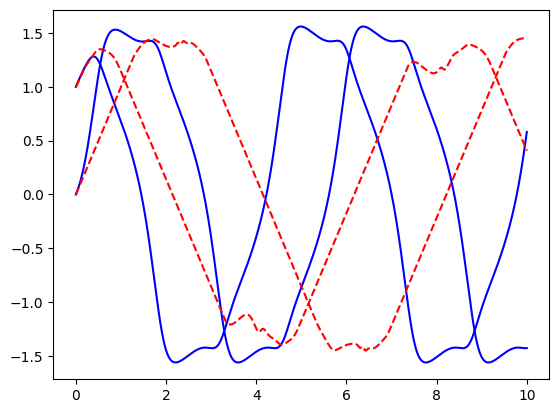

In [96]:
pred_y = odeint(func, true_y0, times)
plt.plot(times.cpu().squeeze(),true_y.cpu().squeeze(),color="blue")
plt.plot(times.cpu().squeeze(),pred_y.detach().numpy().squeeze(),'--',  color="red")

## Increase batch time

In [9]:
torch.manual_seed(0)
func = ODEFunc().to(device)
optimizer = optim.RMSprop(func.parameters(), lr=1e-2)

history = {}
history["losses"] = []
history["params"] = [k.detach().numpy() for k in list(func.parameters())]
history["gradients"] = []


for itr in tqdm(range(1, 1000)):
    optimizer.zero_grad()
    batch_y0, batch_t, batch_y = get_batch(func,batch_size=5, batch_time=100)
    pred_y = odeint(func, batch_y0, batch_t).to(device)
    loss = torch.mean(torch.abs(pred_y - batch_y))#/torch.sum(torch.abs(batch_y)))
    loss.backward()
    optimizer.step()

    if itr % 10 == 0:
        with torch.no_grad():
            pred_y = odeint(func, true_y0, times)
            loss = torch.mean(torch.abs(pred_y - true_y))
            print('Iter {:04d} | Total Loss {:.6f}'.format(itr, loss.item()))
            history["losses"].append(loss.item())
            history["params"].append([k.detach().numpy() for k in list(func.parameters())])
            history["gradients"].append([k.grad for k in list(func.parameters())])
    end = time.time()


  1%|█▌                                                                                                          | 14/999 [00:00<00:50, 19.57it/s]

Iter 0010 | Total Loss 1.855860


  2%|██▍                                                                                                         | 22/999 [00:01<00:55, 17.54it/s]

Iter 0020 | Total Loss 1.744108


  3%|███▋                                                                                                        | 34/999 [00:01<00:56, 16.94it/s]

Iter 0030 | Total Loss 1.131447


  4%|████▋                                                                                                       | 43/999 [00:02<01:03, 15.16it/s]

Iter 0040 | Total Loss 1.242633


  5%|█████▌                                                                                                      | 52/999 [00:03<00:59, 15.85it/s]

Iter 0050 | Total Loss 1.090827


  6%|██████▋                                                                                                     | 62/999 [00:03<01:02, 14.87it/s]

Iter 0060 | Total Loss 0.851146


  7%|████████                                                                                                    | 74/999 [00:04<01:00, 15.21it/s]

Iter 0070 | Total Loss 0.850031


  8%|████████▉                                                                                                   | 83/999 [00:05<00:56, 16.15it/s]

Iter 0080 | Total Loss 0.860096


  9%|█████████▊                                                                                                  | 91/999 [00:05<01:10, 12.87it/s]

Iter 0090 | Total Loss 0.868335


 10%|███████████                                                                                                | 103/999 [00:06<00:58, 15.44it/s]

Iter 0100 | Total Loss 0.735251


 11%|████████████                                                                                               | 113/999 [00:07<01:08, 12.94it/s]

Iter 0110 | Total Loss 0.661041


 12%|█████████████▏                                                                                             | 123/999 [00:07<01:04, 13.52it/s]

Iter 0120 | Total Loss 0.591342


 13%|██████████████▏                                                                                            | 133/999 [00:08<01:05, 13.18it/s]

Iter 0130 | Total Loss 0.564037


 14%|███████████████▎                                                                                           | 143/999 [00:09<01:09, 12.36it/s]

Iter 0140 | Total Loss 0.415458


 15%|████████████████▍                                                                                          | 153/999 [00:10<01:07, 12.61it/s]

Iter 0150 | Total Loss 0.499968


 16%|█████████████████▌                                                                                         | 164/999 [00:10<01:00, 13.77it/s]

Iter 0160 | Total Loss 0.487501


 17%|██████████████████▍                                                                                        | 172/999 [00:11<01:02, 13.29it/s]

Iter 0170 | Total Loss 0.487776


 18%|███████████████████▍                                                                                       | 182/999 [00:12<01:07, 12.10it/s]

Iter 0180 | Total Loss 0.388856


 19%|████████████████████▌                                                                                      | 192/999 [00:13<01:06, 12.06it/s]

Iter 0190 | Total Loss 0.396685


 20%|█████████████████████▋                                                                                     | 202/999 [00:13<00:57, 13.78it/s]

Iter 0200 | Total Loss 0.399762


 21%|██████████████████████▊                                                                                    | 213/999 [00:14<00:57, 13.66it/s]

Iter 0210 | Total Loss 0.379192


 22%|███████████████████████▊                                                                                   | 222/999 [00:15<00:57, 13.45it/s]

Iter 0220 | Total Loss 0.349751


 23%|████████████████████████▊                                                                                  | 232/999 [00:15<01:02, 12.35it/s]

Iter 0230 | Total Loss 0.256402


 24%|█████████████████████████▊                                                                                 | 241/999 [00:16<00:58, 13.04it/s]

Iter 0240 | Total Loss 0.293561


 25%|██████████████████████████▉                                                                                | 252/999 [00:17<00:54, 13.75it/s]

Iter 0250 | Total Loss 0.287934


 26%|████████████████████████████                                                                               | 262/999 [00:18<00:51, 14.23it/s]

Iter 0260 | Total Loss 0.277644


 27%|█████████████████████████████▏                                                                             | 272/999 [00:18<01:00, 12.01it/s]

Iter 0270 | Total Loss 0.215634


 28%|██████████████████████████████▎                                                                            | 283/999 [00:19<00:50, 14.10it/s]

Iter 0280 | Total Loss 0.245350


 29%|███████████████████████████████▏                                                                           | 291/999 [00:20<01:02, 11.29it/s]

Iter 0290 | Total Loss 0.238722


 30%|████████████████████████████████▏                                                                          | 301/999 [00:21<01:01, 11.34it/s]

Iter 0300 | Total Loss 0.189275


 31%|█████████████████████████████████▎                                                                         | 311/999 [00:21<01:06, 10.29it/s]

Iter 0310 | Total Loss 0.186211


 32%|██████████████████████████████████▍                                                                        | 321/999 [00:23<01:18,  8.68it/s]

Iter 0320 | Total Loss 0.155932


 33%|███████████████████████████████████▍                                                                       | 331/999 [00:23<01:05, 10.20it/s]

Iter 0330 | Total Loss 0.164026


 34%|████████████████████████████████████▌                                                                      | 341/999 [00:24<01:09,  9.48it/s]

Iter 0340 | Total Loss 0.135220


 35%|█████████████████████████████████████▌                                                                     | 351/999 [00:25<01:10,  9.22it/s]

Iter 0350 | Total Loss 0.136023


 36%|██████████████████████████████████████▊                                                                    | 362/999 [00:27<01:21,  7.79it/s]

Iter 0360 | Total Loss 0.132793


 37%|███████████████████████████████████████▊                                                                   | 372/999 [00:27<00:59, 10.55it/s]

Iter 0370 | Total Loss 0.137589


 38%|████████████████████████████████████████▉                                                                  | 382/999 [00:28<00:56, 10.90it/s]

Iter 0380 | Total Loss 0.154229


 39%|██████████████████████████████████████████                                                                 | 393/999 [00:29<00:46, 13.04it/s]

Iter 0390 | Total Loss 0.143186


 40%|██████████████████████████████████████████▉                                                                | 401/999 [00:30<01:00,  9.92it/s]

Iter 0400 | Total Loss 0.133273


 41%|████████████████████████████████████████████▏                                                              | 413/999 [00:31<00:59,  9.89it/s]

Iter 0410 | Total Loss 0.143485


 42%|█████████████████████████████████████████████                                                              | 421/999 [00:32<00:52, 10.99it/s]

Iter 0420 | Total Loss 0.128513


 43%|██████████████████████████████████████████████▍                                                            | 433/999 [00:33<00:41, 13.65it/s]

Iter 0430 | Total Loss 0.129028


 44%|███████████████████████████████████████████████▏                                                           | 440/999 [00:33<00:49, 11.18it/s]

Iter 0440 | Total Loss 0.128510


 45%|████████████████████████████████████████████████▎                                                          | 451/999 [00:34<00:58,  9.32it/s]

Iter 0450 | Total Loss 0.133072


 46%|█████████████████████████████████████████████████▍                                                         | 461/999 [00:35<00:58,  9.20it/s]

Iter 0460 | Total Loss 0.127656


 47%|██████████████████████████████████████████████████▋                                                        | 473/999 [00:36<00:45, 11.67it/s]

Iter 0470 | Total Loss 0.133781


 48%|███████████████████████████████████████████████████▋                                                       | 483/999 [00:37<00:42, 12.04it/s]

Iter 0480 | Total Loss 0.126452


 49%|████████████████████████████████████████████████████▋                                                      | 492/999 [00:38<00:41, 12.16it/s]

Iter 0490 | Total Loss 0.133814


 50%|█████████████████████████████████████████████████████▌                                                     | 500/999 [00:39<00:48, 10.22it/s]

Iter 0500 | Total Loss 0.137654


 51%|██████████████████████████████████████████████████████▊                                                    | 512/999 [00:40<00:43, 11.23it/s]

Iter 0510 | Total Loss 0.134312


 52%|███████████████████████████████████████████████████████▉                                                   | 522/999 [00:41<00:47, 10.04it/s]

Iter 0520 | Total Loss 0.124099


 53%|█████████████████████████████████████████████████████████                                                  | 533/999 [00:42<00:36, 12.86it/s]

Iter 0530 | Total Loss 0.129896


 54%|██████████████████████████████████████████████████████████▎                                                | 544/999 [00:42<00:32, 13.95it/s]

Iter 0540 | Total Loss 0.141720


 55%|███████████████████████████████████████████████████████████▏                                               | 553/999 [00:43<00:35, 12.73it/s]

Iter 0550 | Total Loss 0.133218


 56%|████████████████████████████████████████████████████████████▎                                              | 563/999 [00:44<00:35, 12.43it/s]

Iter 0560 | Total Loss 0.119749


 57%|█████████████████████████████████████████████████████████████▏                                             | 571/999 [00:45<00:42, 10.02it/s]

Iter 0570 | Total Loss 0.122403


 58%|██████████████████████████████████████████████████████████████▏                                            | 581/999 [00:46<00:44,  9.33it/s]

Iter 0580 | Total Loss 0.120776


 59%|███████████████████████████████████████████████████████████████▎                                           | 591/999 [00:47<00:42,  9.51it/s]

Iter 0590 | Total Loss 0.124013


 60%|████████████████████████████████████████████████████████████████▌                                          | 603/999 [00:48<00:36, 10.72it/s]

Iter 0600 | Total Loss 0.137924


 61%|█████████████████████████████████████████████████████████████████▍                                         | 611/999 [00:48<00:38, 10.14it/s]

Iter 0610 | Total Loss 0.124979


 62%|██████████████████████████████████████████████████████████████████▌                                        | 621/999 [00:49<00:43,  8.66it/s]

Iter 0620 | Total Loss 0.137540


 63%|███████████████████████████████████████████████████████████████████▌                                       | 631/999 [00:50<00:38,  9.44it/s]

Iter 0630 | Total Loss 0.138612


 64%|████████████████████████████████████████████████████████████████████▋                                      | 641/999 [00:51<00:34, 10.23it/s]

Iter 0640 | Total Loss 0.119480


 65%|█████████████████████████████████████████████████████████████████████▊                                     | 652/999 [00:52<00:32, 10.60it/s]

Iter 0650 | Total Loss 0.122757


 66%|███████████████████████████████████████████████████████████████████████                                    | 663/999 [00:53<00:26, 12.75it/s]

Iter 0660 | Total Loss 0.118840


 67%|███████████████████████████████████████████████████████████████████████▊                                   | 671/999 [00:54<00:29, 11.00it/s]

Iter 0670 | Total Loss 0.120743


 68%|████████████████████████████████████████████████████████████████████████▉                                  | 681/999 [00:55<00:37,  8.40it/s]

Iter 0680 | Total Loss 0.133388


 69%|█████████████████████████████████████████████████████████████████████████▉                                 | 690/999 [00:56<00:33,  9.25it/s]

Iter 0690 | Total Loss 0.127388


 70%|███████████████████████████████████████████████████████████████████████████▏                               | 702/999 [00:57<00:28, 10.49it/s]

Iter 0700 | Total Loss 0.118609


 71%|████████████████████████████████████████████████████████████████████████████▏                              | 711/999 [00:57<00:23, 12.11it/s]

Iter 0710 | Total Loss 0.124262


 72%|█████████████████████████████████████████████████████████████████████████████▎                             | 722/999 [00:58<00:24, 11.36it/s]

Iter 0720 | Total Loss 0.137310


 73%|██████████████████████████████████████████████████████████████████████████████▏                            | 730/999 [00:59<00:24, 10.86it/s]

Iter 0730 | Total Loss 0.145121


 74%|███████████████████████████████████████████████████████████████████████████████▍                           | 742/999 [01:00<00:21, 12.09it/s]

Iter 0740 | Total Loss 0.143406


 75%|████████████████████████████████████████████████████████████████████████████████▋                          | 753/999 [01:01<00:19, 12.45it/s]

Iter 0750 | Total Loss 0.138369


 76%|█████████████████████████████████████████████████████████████████████████████████▌                         | 761/999 [01:02<00:22, 10.42it/s]

Iter 0760 | Total Loss 0.124151


 77%|██████████████████████████████████████████████████████████████████████████████████▌                        | 771/999 [01:02<00:24,  9.19it/s]

Iter 0770 | Total Loss 0.125058


 78%|███████████████████████████████████████████████████████████████████████████████████▊                       | 783/999 [01:04<00:19, 11.01it/s]

Iter 0780 | Total Loss 0.137985


 79%|████████████████████████████████████████████████████████████████████████████████████▋                      | 791/999 [01:04<00:21,  9.73it/s]

Iter 0790 | Total Loss 0.128256


 80%|█████████████████████████████████████████████████████████████████████████████████████▉                     | 802/999 [01:05<00:19,  9.98it/s]

Iter 0800 | Total Loss 0.119260


 81%|██████████████████████████████████████████████████████████████████████████████████████▊                    | 811/999 [01:06<00:17, 10.91it/s]

Iter 0810 | Total Loss 0.120409


 82%|███████████████████████████████████████████████████████████████████████████████████████▉                   | 821/999 [01:07<00:19,  9.23it/s]

Iter 0820 | Total Loss 0.137263


 83%|█████████████████████████████████████████████████████████████████████████████████████████                  | 832/999 [01:08<00:14, 11.46it/s]

Iter 0830 | Total Loss 0.135298


 84%|█████████████████████████████████████████████████████████████████████████████████████████▉                 | 840/999 [01:09<00:17,  9.24it/s]

Iter 0840 | Total Loss 0.126463


 85%|███████████████████████████████████████████████████████████████████████████████████████████▎               | 852/999 [01:10<00:12, 11.82it/s]

Iter 0850 | Total Loss 0.140321


 86%|████████████████████████████████████████████████████████████████████████████████████████████               | 860/999 [01:11<00:14,  9.49it/s]

Iter 0860 | Total Loss 0.125268


 87%|█████████████████████████████████████████████████████████████████████████████████████████████▎             | 871/999 [01:12<00:15,  8.47it/s]

Iter 0870 | Total Loss 0.131295


 88%|██████████████████████████████████████████████████████████████████████████████████████████████▍            | 882/999 [01:13<00:10, 10.68it/s]

Iter 0880 | Total Loss 0.132248


 89%|███████████████████████████████████████████████████████████████████████████████████████████████▋           | 893/999 [01:14<00:08, 12.03it/s]

Iter 0890 | Total Loss 0.132104


 90%|████████████████████████████████████████████████████████████████████████████████████████████████▌          | 902/999 [01:14<00:08, 11.07it/s]

Iter 0900 | Total Loss 0.130145


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████▌         | 911/999 [01:15<00:08, 10.20it/s]

Iter 0910 | Total Loss 0.122326


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████▋        | 921/999 [01:16<00:10,  7.62it/s]

Iter 0920 | Total Loss 0.130030


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████▋       | 931/999 [01:17<00:07,  9.20it/s]

Iter 0930 | Total Loss 0.118756


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████      | 943/999 [01:18<00:04, 13.04it/s]

Iter 0940 | Total Loss 0.122199


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████     | 953/999 [01:19<00:03, 13.19it/s]

Iter 0950 | Total Loss 0.137685


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 963/999 [01:20<00:02, 13.77it/s]

Iter 0960 | Total Loss 0.136773


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████   | 971/999 [01:21<00:02, 10.53it/s]

Iter 0970 | Total Loss 0.117325


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 982/999 [01:21<00:01, 12.10it/s]

Iter 0980 | Total Loss 0.121954


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 991/999 [01:23<00:00,  8.06it/s]

Iter 0990 | Total Loss 0.131180


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 999/999 [01:23<00:00, 11.94it/s]


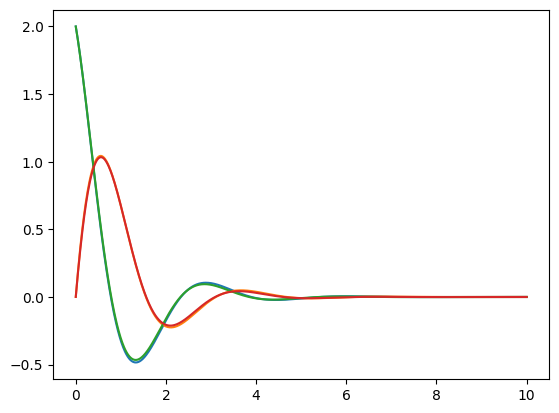

In [17]:
pred_y = odeint(func, true_y0, times)
plt.plot(times.cpu().squeeze(),true_y.cpu().squeeze())
plt.plot(times.cpu().squeeze(),pred_y.detach().numpy().squeeze())